# Transfer Learning
## Multi-modal Multi-tasking

Yasmin Femerling, Alejandro de Leon

4/7/2021

### The Dataset

For this lab, a dataset containing some of the Pokemon collection was chosen. The idea is to perform a multi-task classification to predict what types of pokemon a particular sample has. There are 18 types of Pokemons in our dataset, as described in the next list:

- Normal
- Fighting
- Flying
- Posion
- Ground
- Rock
- Bug
- Ghost
- Steel
- Fire
- Water
- Grass
- Electric
- Psychic
- Ice
- Dragon
- Fairy
- Dark

Each pokemon can have up to two classifications, a primary type and a secondary type. The dataset contains images of all Pokemon from generation 1 to generation 7, each image depicts a different pokemon. In total there are 809 images, 721 in .png format and 88 in .jpg format. 

The data was collected to predict Pokemon primary and secondary types from the images and to identify the evolution form from a pokemon based on the pre-evolved forms. In this lab, we focused on the first task, classification. The data was scraped in 2019 from the pokedex and contains information and labels in the form of a .csv. 


### The Goal

The classification is a difficult task because there are only 809 images, one per pokemon on the database. It is a multi-task problem, where the pokemon need to be classified in each task but in only one network. The most direct way would be to make a neural network that could classify all the pokemon using only categorial crossentropy, where each label class is one of the types of pokemon. The primary type of the pokemon could be one task, and the secondary type could be a second task. This would yield a network that could classify the pokemon with only two tasks. 

A second approach would be to consider a more fine-task methodology, where there are 18 branches, each in charge of classifying the pokemon as part or not part of the certain pokemon type using binary crossentropy. We will take advantage of this to try to understand multi-task networks more. 

### Tasks

In the first solution (categorical) there are two tasks: the first task is to classify the primary type of the pokemon. The second task is to classify the secondary task of the pokemon. 

In the second solution (binary) we will consider 7 tasks, one per pokemon type of interest. We will focus on the water, electric, fire, rock, grass,  and. 

The tasks are within the same domain because they all focus on identifying the type of pokemon from an image.  

### Training and Testing data

The data will be split in the following way, from all the images 80% will be for training and 20% for validation. Various exercises, models in literature, and tips from the machine learning community lead to the belief that splitting the data in this manner is a good way. About 20-30% in the data for validation is recommended. It is also better to not leave a higher percentage of the data into validation because the data in this exercise is low, that is why we will make the training data 80% of the images. This will be done by splitting the data and labels with a keras function. 

### Evaluation 

The evaluation will be done using the accuracy metric. This is because the tasks are simple classification tasks of images. Normally in classification models accuracy is a good measure becase the model can be valued comparing the images it is classifying to their label. 


## General Model

A general model for this problem would include classification of all the pokemon by its type. One way to do this could be to consider the primary type of the pokemon and make a neural network with categorical crossentropy to classify it. The idea is to have one input, one output and classify the pokemon. 




In [1]:
# Imports

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import matplotlib.pyplot as plt
from ipynb.fs.full.utilities import *

We create the PokemonNet. The general model will only classify the primary type of the pokemon. 

In [18]:
class PokemonNet:
    
    # The head layers that classify the pokemon
    
    @staticmethod
    def build_type1_branch(inputs, numType1, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(numType1)(x)
        x = Activation(finalAct, name="type1_classification")(x)
        
        return x
        
    # The bottom convolutional layers
    
    @staticmethod
    def build_model(width, height, numType1, numType2=0, finalAct="sigmoid"):
        
        inputs = Input(shape=(width, height, 3))

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        
        # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        
        # Constructing type 1 head.
        type1_branch = PokemonNet.build_type1_branch(x, numType1, finalAct)
        
        # Building the model
        print("Building model...")
        model = Model(
            inputs=inputs,
            outputs=[type1_branch],
            name="pokemonnet"
                     )
        
        return model    
    
    # Use of data generator to make data augmentation, avoid too much overfitting
    @staticmethod
    def net_generator(generator, data, label1, label2, batch_s):
        gen1 = generator.flow(data, label1, batch_size=batch_s)
        while True:
            X1 = gen1.next()
            yield X1[0], X1[1]
        
        

We get the labels from the csv from the dataset.  The getTypeLabels() function will return an array that specifies the type of pokemon from the dataset. The  pokemon in the image folder and the pokemon in the .csv are in alphabetical order to make sure that they match.  

In [22]:
# Initial parameters 

EPOCHS = 50
BATCH_SIZE = 32
IMG_DIMS = [150, 150]
ACTIVATION = 'sigmoid'


# Extracting images
data = load_images('images/images', IMG_DIMS)

# Values between [0, 1]
data = np.array(data, dtype='float')/255.0

# Binarize sets of labels
type1LB = LabelBinarizer()
type1Labels = type1LB.fit_transform(getTypeLabels('pokemon_2.csv', 'Type1'))

# Split data into training and validation
split = train_test_split(data, type1Labels, test_size=0.2)
(trainX, testX, trainType1Y, testType1Y) = split

# defining dictionary with respective losses.
losses = {
    "type1_classification": "categorical_crossentropy"
}

# Creating model
model = PokemonNet.build_model(IMG_DIMS[0], IMG_DIMS[1], 
                               numType1=len(type1LB.classes_),
                               finalAct= ACTIVATION)

model.compile(optimizer='adam', loss=losses, metrics=["accuracy"])

# Displaying model summary
model.summary()

# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# train the network to perform multi-output classification
H = model.fit(PokemonNet.net_generator(datagen, trainX, trainType1Y, 0, batch_s=BATCH_SIZE),
        validation_data=(testX, testType1Y),
        steps_per_epoch=len(trainX)/BATCH_SIZE,
        validation_steps=len(testX)/BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1)

# Save model
model.save('pokemon_model_final_1.h5', save_format='h5' )

Building model...
Model: "pokemonnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
activation_18 (Activation)   (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_19 (Activation)   (None, 50

/Library/Python/3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Library/Python/3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
20/20 [==============================] - 13s 595ms/step - loss: 2.8522 - accuracy: 0.1088 - val_loss: 2.7570 - val_accuracy: 0.1296
Epoch 2/50
20/20 [==============================] - 14s 718ms/step - loss: 2.7356 - accuracy: 0.1052 - val_loss: 2.7683 - val_accuracy: 0.1420
Epoch 3/50
20/20 [==============================] - 16s 796ms/step - loss: 2.7303 - accuracy: 0.1612 - val_loss: 2.7611 - val_accuracy: 0.1296
Epoch 4/50
20/20 [==============================] - 21s 1s/step - loss: 2.7097 - accuracy: 0.1477 - val_loss: 2.7635 - val_accuracy: 0.1296
Epoch 5/50
20/20 [==============================] - 19s 945ms/step - loss: 2.6882 - accuracy: 0.1237 - val_loss: 2.7627 - val_accuracy: 0.1296
Epoch 6/50
20/20 [==============================] - 18s 895ms/step - loss: 2.7005 - accuracy: 0.1655 - val_loss: 2.7737 - val_accuracy: 0.1296
Epoch 7/50
20/20 [==============================] - 18s 891ms/step - loss: 2.6835 - accuracy: 0.1446 - val_loss: 2.7594 - val_accuracy: 0.1296
Ep

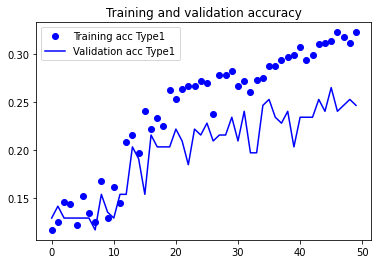

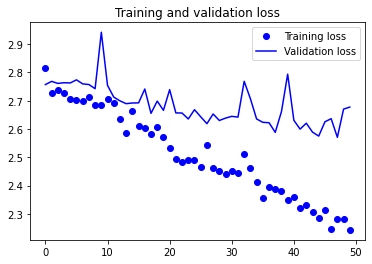

In [27]:
# Plot results

acc1 = H.history['accuracy']
val_acc1 = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(len(acc1))

plt.plot(epochs, acc1, 'bo', label='Training acc Type1')
plt.plot(epochs, val_acc1, 'b', label='Validation acc Type1')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("model_final_1.png")
plt.figure()

plt.plot(epochs,b loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("model_final_2.png")
plt.show()


The model is overfitting, the losses were dropping, until the validation loss started to stabilize, and the accuracies were increasing until the validation accuracy started to stabilize. With more epochs, the model would likely yield a model that is too overfitted. 

We can see from the accuracy that only about 25% of the images are being classified correctly, which is very low. The results depict that the performance of the model is not good, it will fail to classify wrongly most of the images.

We now test the model with a few external images: 

[INFO] loading network...
[INFO] classifying image...

 [RESULT] Type1: Water Probability: 97.39% 

[INFO] loading network...
[INFO] classifying image...

 [RESULT] Type1: Normal Probability: 69.96% 

[INFO] loading network...
[INFO] classifying image...

 [RESULT] Type1: Fire Probability: 99.98% 

[INFO] loading network...
[INFO] classifying image...

 [RESULT] Type1: Grass Probability: 70.14% 



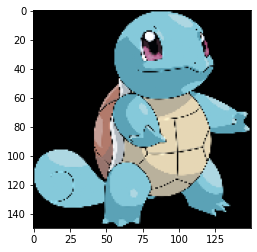

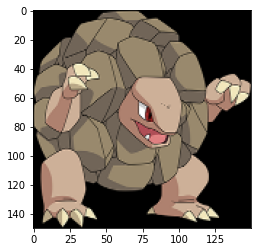

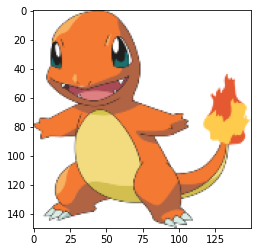

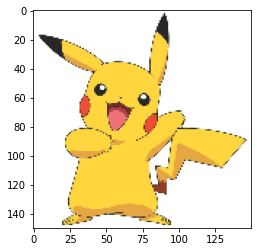

In [46]:
# Test model
MODEL_PATH='pokemon_model_final_1.h5'
TEST_IMAGE='water.png'

# load the image
image = cv2.imread(TEST_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# pre-process the image for classification
image = cv2.resize(image, (150, 150))
image = image.astype("float") / 255.0
image = img_to_array(image)
plt.imshow(image)
image = np.expand_dims(image, axis=0)

# loading model
print("[INFO] loading network...")
model = load_model(MODEL_PATH)

# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
type1Proba = model.predict(image)
type1Idx = type1Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]

print(f'\n [RESULT] Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n')

# Test model
MODEL_PATH='pokemon_model_final_1.h5'
TEST_IMAGE='rock.png'

# load the image
image = cv2.imread(TEST_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# pre-process the image for classification
image = cv2.resize(image, (150, 150))
image = image.astype("float") / 255.0
image = img_to_array(image)
plt.figure()
plt.imshow(image)
image = np.expand_dims(image, axis=0)

# loading model
print("[INFO] loading network...")
model = load_model(MODEL_PATH)

# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
type1Proba = model.predict(image)
type1Idx = type1Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]

print(f'\n [RESULT] Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n')


# Test model
MODEL_PATH='pokemon_model_final_1.h5'
TEST_IMAGE='fire.png'

# load the image
image = cv2.imread(TEST_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# pre-process the image for classification
image = cv2.resize(image, (150, 150))
image = image.astype("float") / 255.0
image = img_to_array(image)
plt.figure()
plt.imshow(image)
image = np.expand_dims(image, axis=0)

# loading model
print("[INFO] loading network...")
model = load_model(MODEL_PATH)

# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
type1Proba = model.predict(image)
type1Idx = type1Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]

print(f'\n [RESULT] Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n')

# Test model
MODEL_PATH='pokemon_model_final_1.h5'
TEST_IMAGE='electric.jpg'

# load the image
image = cv2.imread(TEST_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# pre-process the image for classification
image = cv2.resize(image, (150, 150))
image = image.astype("float") / 255.0
image = img_to_array(image)
plt.figure()
plt.imshow(image)
image = np.expand_dims(image, axis=0)

# loading model
print("[INFO] loading network...")
model = load_model(MODEL_PATH)

# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
type1Proba = model.predict(image)
type1Idx = type1Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]

print(f'\n [RESULT] Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n')


We used:
- Squirtle, which is a water type pokemon, 
- Golem, which is a rock type pokemon, 
- Charmander, which is a fire type pokemon
- Pikachu, which is an electric type pokemon. 

The model is not very good, as we had seen from the results from the training. But it is able to predict some pokemon types. 

It predicted: 
- Squirtle as a water type with 97.39%
- Golem as normal with 69.96%
- Charmander as fire with 99.98%
- Pikachu as grass with 70.14%. 
Still, it can't be considered a reliable model. Only Squirtle and Charmander were correct. 

## First Multi-task

The next step would be to create the multitask. We will make a few adjustments to the previous PokemonNet. The idea is to create another branch, so that the two branches will classify the pokemon with its primary and its secondary type. We make use of the PokemonNet class, adjusting it to have two branches. 

In [ ]:
class PokemonNet:
    
    @staticmethod
    def build_type1_branch(inputs, numType1, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(numType1)(x)
        x = Activation(finalAct, name="type1_classification")(x)
        
        return x
        
    @staticmethod
    def build_type2_branch(inputs, numType2, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(numType2)(x)
        x = Activation(finalAct, name="type2_classification")(x)
        
        return x
    
    @staticmethod
    def build_model(width, height, numType1, numType2, finalAct="sigmoid"):
        
        inputs = Input(shape=(width, height, 3))

        """
        # build the VGG16 network, leaving off the top classifier layer
        # so we just get the features as output
        print('Building VGG16...')
        
        base_model = VGG16(weights='imagenet', 
                           include_top=False, 
                           input_tensor=inputs)
        """
        
        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        
        # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        
        # Constructing type 1 and type 2 heads.
        type1_branch = PokemonNet.build_type1_branch(x, numType1, finalAct)
        type2_branch = PokemonNet.build_type2_branch(x, numType2, finalAct)
        
        # Building the model
        print("Building model...")
        model = Model(
            inputs=inputs,
            outputs=[type1_branch, type2_branch],
            name="pokemonnet"
                     )
        
        return model    
    
    @staticmethod
    def net_generator(generator, data, label1, label2, batch_s):
        gen1 = generator.flow(data, label1, batch_size=batch_s)
        gen2 = generator.flow(data, label2, batch_size=batch_s)
        while True:
            X1 = gen1.next()
            X2 = gen2.next()
            yield X1[0], [X1[1], X2[1]] 
        
        

In [ ]:
Building model...
Model: "pokemonnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_7 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 150, 150, 32) 896         input_7[0][0]                    
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 150, 150, 32) 0           conv2d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 50, 50, 32)   0           activation_42[0][0]              
__________________________________________________________________________________________________
dropout_30 (Dropout)            (None, 50, 50, 32)   0           max_pooling2d_18[0][0]           
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 50, 50, 64)   18496       dropout_30[0][0]                 
__________________________________________________________________________________________________
activation_43 (Activation)      (None, 50, 50, 64)   0           conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 50, 50, 64)   36928       activation_43[0][0]              
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 50, 50, 64)   0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 25, 25, 64)   0           activation_44[0][0]              
__________________________________________________________________________________________________
dropout_31 (Dropout)            (None, 25, 25, 64)   0           max_pooling2d_19[0][0]           
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 25, 25, 128)  73856       dropout_31[0][0]                 
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 25, 25, 128)  0           conv2d_33[0][0]                  
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 25, 25, 128)  147584      activation_45[0][0]              
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 25, 25, 128)  0           conv2d_34[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 12, 12, 128)  0           activation_46[0][0]              
__________________________________________________________________________________________________
dropout_32 (Dropout)            (None, 12, 12, 128)  0           max_pooling2d_20[0][0]           
__________________________________________________________________________________________________
flatten_12 (Flatten)            (None, 18432)        0           dropout_32[0][0]                 
__________________________________________________________________________________________________
flatten_13 (Flatten)            (None, 18432)        0           dropout_32[0][0]                 
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 256)          4718848     flatten_12[0][0]                 
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 256)          4718848     flatten_13[0][0]                 
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 256)          0           dense_24[0][0]                   
__________________________________________________________________________________________________
activation_48 (Activation)      (None, 256)          0           dense_26[0][0]                   
__________________________________________________________________________________________________
dropout_33 (Dropout)            (None, 256)          0           activation_47[0][0]              
__________________________________________________________________________________________________
dropout_34 (Dropout)            (None, 256)          0           activation_48[0][0]              
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 18)           4626        dropout_33[0][0]                 
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 19)           4883        dropout_34[0][0]                 
__________________________________________________________________________________________________
type1_classification (Activatio (None, 18)           0           dense_25[0][0]                   
__________________________________________________________________________________________________
type2_classification (Activatio (None, 19)           0           dense_27[0][0]                   
==================================================================================================
Total params: 9,724,965
Trainable params: 9,724,965
Non-trainable params: 0
__________________________________________________________________________________________________
C:\Users\Alejandro de Leon\AppData\Roaming\Python\Python38\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Alejandro de Leon\AppData\Roaming\Python\Python38\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
Epoch 1/50
20/20 [==============================] - 11s 506ms/step - loss: 5.3786 - type1_classification_loss: 2.8727 - type2_classification_loss: 2.5059 - type1_classification_accuracy: 0.1055 - type2_classification_accuracy: 0.3739 - val_loss: 4.6943 - val_type1_classification_loss: 2.7494 - val_type2_classification_loss: 1.9449 - val_type1_classification_accuracy: 0.1296 - val_type2_classification_accuracy: 0.5432
Epoch 2/50
20/20 [==============================] - 10s 503ms/step - loss: 4.7348 - type1_classification_loss: 2.6657 - type2_classification_loss: 2.0691 - type1_classification_accuracy: 0.1722 - type2_classification_accuracy: 0.4957 - val_loss: 4.7741 - val_type1_classification_loss: 2.7500 - val_type2_classification_loss: 2.0241 - val_type1_classification_accuracy: 0.1605 - val_type2_classification_accuracy: 0.5247
Epoch 3/50
20/20 [==============================] - 10s 504ms/step - loss: 4.8280 - type1_classification_loss: 2.7099 - type2_classification_loss: 2.1181 - type1_classification_accuracy: 0.1493 - type2_classification_accuracy: 0.4809 - val_loss: 4.7169 - val_type1_classification_loss: 2.7350 - val_type2_classification_loss: 1.9819 - val_type1_classification_accuracy: 0.1173 - val_type2_classification_accuracy: 0.5185
Epoch 4/50
20/20 [==============================] - 10s 504ms/step - loss: 4.8899 - type1_classification_loss: 2.7400 - type2_classification_loss: 2.1499 - type1_classification_accuracy: 0.1356 - type2_classification_accuracy: 0.4968 - val_loss: 4.6026 - val_type1_classification_loss: 2.7255 - val_type2_classification_loss: 1.8771 - val_type1_classification_accuracy: 0.1543 - val_type2_classification_accuracy: 0.5864
Epoch 5/50
20/20 [==============================] - 10s 504ms/step - loss: 4.7401 - type1_classification_loss: 2.6950 - type2_classification_loss: 2.0451 - type1_classification_accuracy: 0.1503 - type2_classification_accuracy: 0.5037 - val_loss: 4.8165 - val_type1_classification_loss: 2.7961 - val_type2_classification_loss: 2.0204 - val_type1_classification_accuracy: 0.0988 - val_type2_classification_accuracy: 0.4938
Epoch 6/50
20/20 [==============================] - 10s 492ms/step - loss: 4.8815 - type1_classification_loss: 2.7268 - type2_classification_loss: 2.1547 - type1_classification_accuracy: 0.1248 - type2_classification_accuracy: 0.4879 - val_loss: 4.6603 - val_type1_classification_loss: 2.7359 - val_type2_classification_loss: 1.9244 - val_type1_classification_accuracy: 0.1111 - val_type2_classification_accuracy: 0.5494
Epoch 7/50
20/20 [==============================] - 10s 488ms/step - loss: 4.7892 - type1_classification_loss: 2.6968 - type2_classification_loss: 2.0924 - type1_classification_accuracy: 0.1219 - type2_classification_accuracy: 0.4807 - val_loss: 4.6600 - val_type1_classification_loss: 2.7479 - val_type2_classification_loss: 1.9120 - val_type1_classification_accuracy: 0.1296 - val_type2_classification_accuracy: 0.5432
Epoch 8/50
20/20 [==============================] - 10s 499ms/step - loss: 4.8929 - type1_classification_loss: 2.7371 - type2_classification_loss: 2.1557 - type1_classification_accuracy: 0.1401 - type2_classification_accuracy: 0.4598 - val_loss: 4.7346 - val_type1_classification_loss: 2.7949 - val_type2_classification_loss: 1.9397 - val_type1_classification_accuracy: 0.1111 - val_type2_classification_accuracy: 0.5185
Epoch 9/50
20/20 [==============================] - 10s 501ms/step - loss: 4.8492 - type1_classification_loss: 2.6935 - type2_classification_loss: 2.1557 - type1_classification_accuracy: 0.1325 - type2_classification_accuracy: 0.4668 - val_loss: 4.6711 - val_type1_classification_loss: 2.7785 - val_type2_classification_loss: 1.8926 - val_type1_classification_accuracy: 0.1173 - val_type2_classification_accuracy: 0.5617
Epoch 10/50
20/20 [==============================] - 10s 498ms/step - loss: 4.8495 - type1_classification_loss: 2.7430 - type2_classification_loss: 2.1065 - type1_classification_accuracy: 0.1269 - type2_classification_accuracy: 0.4868 - val_loss: 4.5568 - val_type1_classification_loss: 2.7455 - val_type2_classification_loss: 1.8113 - val_type1_classification_accuracy: 0.1173 - val_type2_classification_accuracy: 0.5802
Epoch 11/50
20/20 [==============================] - 10s 504ms/step - loss: 4.8623 - type1_classification_loss: 2.7290 - type2_classification_loss: 2.1333 - type1_classification_accuracy: 0.1408 - type2_classification_accuracy: 0.4802 - val_loss: 4.6656 - val_type1_classification_loss: 2.7578 - val_type2_classification_loss: 1.9078 - val_type1_classification_accuracy: 0.1235 - val_type2_classification_accuracy: 0.5679
Epoch 12/50
20/20 [==============================] - 10s 493ms/step - loss: 4.8193 - type1_classification_loss: 2.6803 - type2_classification_loss: 2.1391 - type1_classification_accuracy: 0.1443 - type2_classification_accuracy: 0.4761 - val_loss: 4.6816 - val_type1_classification_loss: 2.7417 - val_type2_classification_loss: 1.9400 - val_type1_classification_accuracy: 0.1296 - val_type2_classification_accuracy: 0.5432
Epoch 13/50
20/20 [==============================] - 10s 492ms/step - loss: 4.7714 - type1_classification_loss: 2.7071 - type2_classification_loss: 2.0643 - type1_classification_accuracy: 0.1456 - type2_classification_accuracy: 0.4820 - val_loss: 4.6608 - val_type1_classification_loss: 2.7374 - val_type2_classification_loss: 1.9234 - val_type1_classification_accuracy: 0.1296 - val_type2_classification_accuracy: 0.5432
Epoch 14/50
20/20 [==============================] - 10s 498ms/step - loss: 4.7254 - type1_classification_loss: 2.6833 - type2_classification_loss: 2.0421 - type1_classification_accuracy: 0.1216 - type2_classification_accuracy: 0.4826 - val_loss: 4.6752 - val_type1_classification_loss: 2.7746 - val_type2_classification_loss: 1.9005 - val_type1_classification_accuracy: 0.1235 - val_type2_classification_accuracy: 0.5556
Epoch 15/50
20/20 [==============================] - 10s 500ms/step - loss: 4.6541 - type1_classification_loss: 2.6843 - type2_classification_loss: 1.9698 - type1_classification_accuracy: 0.1518 - type2_classification_accuracy: 0.5231 - val_loss: 4.7423 - val_type1_classification_loss: 2.7540 - val_type2_classification_loss: 1.9882 - val_type1_classification_accuracy: 0.1296 - val_type2_classification_accuracy: 0.5123
Epoch 16/50
20/20 [==============================] - 10s 501ms/step - loss: 4.7281 - type1_classification_loss: 2.6845 - type2_classification_loss: 2.0436 - type1_classification_accuracy: 0.1212 - type2_classification_accuracy: 0.4978 - val_loss: 4.5599 - val_type1_classification_loss: 2.6936 - val_type2_classification_loss: 1.8663 - val_type1_classification_accuracy: 0.0988 - val_type2_classification_accuracy: 0.5741
Epoch 17/50
20/20 [==============================] - 10s 503ms/step - loss: 4.7580 - type1_classification_loss: 2.6863 - type2_classification_loss: 2.0717 - type1_classification_accuracy: 0.1390 - type2_classification_accuracy: 0.4799 - val_loss: 4.7240 - val_type1_classification_loss: 2.7735 - val_type2_classification_loss: 1.9504 - val_type1_classification_accuracy: 0.1296 - val_type2_classification_accuracy: 0.5309
Epoch 18/50
20/20 [==============================] - 10s 491ms/step - loss: 4.7218 - type1_classification_loss: 2.7041 - type2_classification_loss: 2.0177 - type1_classification_accuracy: 0.1359 - type2_classification_accuracy: 0.5084 - val_loss: 4.6610 - val_type1_classification_loss: 2.7411 - val_type2_classification_loss: 1.9199 - val_type1_classification_accuracy: 0.1358 - val_type2_classification_accuracy: 0.5432
Epoch 19/50
20/20 [==============================] - 10s 500ms/step - loss: 4.7668 - type1_classification_loss: 2.7047 - type2_classification_loss: 2.0621 - type1_classification_accuracy: 0.1313 - type2_classification_accuracy: 0.4822 - val_loss: 4.6564 - val_type1_classification_loss: 2.7425 - val_type2_classification_loss: 1.9139 - val_type1_classification_accuracy: 0.1358 - val_type2_classification_accuracy: 0.5432
Epoch 20/50
20/20 [==============================] - 10s 491ms/step - loss: 4.6459 - type1_classification_loss: 2.6753 - type2_classification_loss: 1.9707 - type1_classification_accuracy: 0.1474 - type2_classification_accuracy: 0.5333 - val_loss: 4.6565 - val_type1_classification_loss: 2.7604 - val_type2_classification_loss: 1.8961 - val_type1_classification_accuracy: 0.1111 - val_type2_classification_accuracy: 0.5432
Epoch 21/50
20/20 [==============================] - 10s 519ms/step - loss: 4.7385 - type1_classification_loss: 2.7105 - type2_classification_loss: 2.0280 - type1_classification_accuracy: 0.1450 - type2_classification_accuracy: 0.4966 - val_loss: 4.7245 - val_type1_classification_loss: 2.7925 - val_type2_classification_loss: 1.9320 - val_type1_classification_accuracy: 0.1296 - val_type2_classification_accuracy: 0.5494
Epoch 22/50
20/20 [==============================] - 10s 500ms/step - loss: 4.8800 - type1_classification_loss: 2.6959 - type2_classification_loss: 2.1842 - type1_classification_accuracy: 0.1472 - type2_classification_accuracy: 0.4455 - val_loss: 4.6757 - val_type1_classification_loss: 2.7177 - val_type2_classification_loss: 1.9579 - val_type1_classification_accuracy: 0.1111 - val_type2_classification_accuracy: 0.5247
Epoch 23/50
20/20 [==============================] - 10s 505ms/step - loss: 4.7422 - type1_classification_loss: 2.7208 - type2_classification_loss: 2.0213 - type1_classification_accuracy: 0.1332 - type2_classification_accuracy: 0.5083 - val_loss: 4.6285 - val_type1_classification_loss: 2.7393 - val_type2_classification_loss: 1.8892 - val_type1_classification_accuracy: 0.1667 - val_type2_classification_accuracy: 0.5556
Epoch 24/50
20/20 [==============================] - 11s 534ms/step - loss: 4.8166 - type1_classification_loss: 2.7348 - type2_classification_loss: 2.0818 - type1_classification_accuracy: 0.1268 - type2_classification_accuracy: 0.4906 - val_loss: 4.6784 - val_type1_classification_loss: 2.7551 - val_type2_classification_loss: 1.9232 - val_type1_classification_accuracy: 0.1235 - val_type2_classification_accuracy: 0.5432
Epoch 25/50
20/20 [==============================] - 10s 513ms/step - loss: 4.7404 - type1_classification_loss: 2.7003 - type2_classification_loss: 2.0401 - type1_classification_accuracy: 0.1413 - type2_classification_accuracy: 0.5042 - val_loss: 4.6792 - val_type1_classification_loss: 2.7444 - val_type2_classification_loss: 1.9347 - val_type1_classification_accuracy: 0.1296 - val_type2_classification_accuracy: 0.5432
Epoch 26/50
20/20 [==============================] - 10s 501ms/step - loss: 4.7351 - type1_classification_loss: 2.6795 - type2_classification_loss: 2.0556 - type1_classification_accuracy: 0.1464 - type2_classification_accuracy: 0.4944 - val_loss: 4.6851 - val_type1_classification_loss: 2.7770 - val_type2_classification_loss: 1.9080 - val_type1_classification_accuracy: 0.1173 - val_type2_classification_accuracy: 0.5741
Epoch 27/50
20/20 [==============================] - 10s 506ms/step - loss: 4.8128 - type1_classification_loss: 2.7167 - type2_classification_loss: 2.0962 - type1_classification_accuracy: 0.1448 - type2_classification_accuracy: 0.4760 - val_loss: 4.6167 - val_type1_classification_loss: 2.6970 - val_type2_classification_loss: 1.9197 - val_type1_classification_accuracy: 0.1420 - val_type2_classification_accuracy: 0.5494
Epoch 28/50
20/20 [==============================] - 10s 500ms/step - loss: 4.8129 - type1_classification_loss: 2.6893 - type2_classification_loss: 2.1236 - type1_classification_accuracy: 0.1625 - type2_classification_accuracy: 0.4757 - val_loss: 4.6605 - val_type1_classification_loss: 2.6781 - val_type2_classification_loss: 1.9824 - val_type1_classification_accuracy: 0.1420 - val_type2_classification_accuracy: 0.5247
Epoch 29/50
20/20 [==============================] - 10s 493ms/step - loss: 4.7423 - type1_classification_loss: 2.7201 - type2_classification_loss: 2.0222 - type1_classification_accuracy: 0.1361 - type2_classification_accuracy: 0.4970 - val_loss: 4.7057 - val_type1_classification_loss: 2.7819 - val_type2_classification_loss: 1.9238 - val_type1_classification_accuracy: 0.1049 - val_type2_classification_accuracy: 0.5432
Epoch 30/50
20/20 [==============================] - 10s 482ms/step - loss: 4.7328 - type1_classification_loss: 2.6492 - type2_classification_loss: 2.0835 - type1_classification_accuracy: 0.1598 - type2_classification_accuracy: 0.4721 - val_loss: 4.6631 - val_type1_classification_loss: 2.7412 - val_type2_classification_loss: 1.9219 - val_type1_classification_accuracy: 0.1296 - val_type2_classification_accuracy: 0.5494
Epoch 31/50
20/20 [==============================] - 10s 489ms/step - loss: 4.8208 - type1_classification_loss: 2.7186 - type2_classification_loss: 2.1022 - type1_classification_accuracy: 0.1148 - type2_classification_accuracy: 0.4929 - val_loss: 4.6577 - val_type1_classification_loss: 2.7437 - val_type2_classification_loss: 1.9140 - val_type1_classification_accuracy: 0.1296 - val_type2_classification_accuracy: 0.5432
Epoch 32/50
20/20 [==============================] - 10s 497ms/step - loss: 4.7557 - type1_classification_loss: 2.6833 - type2_classification_loss: 2.0724 - type1_classification_accuracy: 0.1344 - type2_classification_accuracy: 0.4837 - val_loss: 4.7403 - val_type1_classification_loss: 2.7274 - val_type2_classification_loss: 2.0129 - val_type1_classification_accuracy: 0.1420 - val_type2_classification_accuracy: 0.5185
Epoch 33/50
20/20 [==============================] - 10s 492ms/step - loss: 4.7255 - type1_classification_loss: 2.6956 - type2_classification_loss: 2.0299 - type1_classification_accuracy: 0.1596 - type2_classification_accuracy: 0.4937 - val_loss: 4.6450 - val_type1_classification_loss: 2.7686 - val_type2_classification_loss: 1.8764 - val_type1_classification_accuracy: 0.1049 - val_type2_classification_accuracy: 0.5926
Epoch 34/50
20/20 [==============================] - 10s 491ms/step - loss: 4.8132 - type1_classification_loss: 2.7286 - type2_classification_loss: 2.0847 - type1_classification_accuracy: 0.1278 - type2_classification_accuracy: 0.4899 - val_loss: 4.5819 - val_type1_classification_loss: 2.7265 - val_type2_classification_loss: 1.8555 - val_type1_classification_accuracy: 0.1235 - val_type2_classification_accuracy: 0.5741
Epoch 35/50
20/20 [==============================] - 10s 499ms/step - loss: 4.7183 - type1_classification_loss: 2.6797 - type2_classification_loss: 2.0386 - type1_classification_accuracy: 0.1145 - type2_classification_accuracy: 0.4872 - val_loss: 4.7128 - val_type1_classification_loss: 2.7370 - val_type2_classification_loss: 1.9757 - val_type1_classification_accuracy: 0.1358 - val_type2_classification_accuracy: 0.5123
Epoch 36/50
20/20 [==============================] - 10s 479ms/step - loss: 4.7882 - type1_classification_loss: 2.7091 - type2_classification_loss: 2.0791 - type1_classification_accuracy: 0.1224 - type2_classification_accuracy: 0.4803 - val_loss: 4.6572 - val_type1_classification_loss: 2.7335 - val_type2_classification_loss: 1.9238 - val_type1_classification_accuracy: 0.1358 - val_type2_classification_accuracy: 0.5432
Epoch 37/50
20/20 [==============================] - 10s 494ms/step - loss: 4.7317 - type1_classification_loss: 2.7178 - type2_classification_loss: 2.0139 - type1_classification_accuracy: 0.1089 - type2_classification_accuracy: 0.4973 - val_loss: 4.6675 - val_type1_classification_loss: 2.7395 - val_type2_classification_loss: 1.9280 - val_type1_classification_accuracy: 0.1296 - val_type2_classification_accuracy: 0.5432
Epoch 38/50
20/20 [==============================] - 10s 491ms/step - loss: 4.7543 - type1_classification_loss: 2.7041 - type2_classification_loss: 2.0502 - type1_classification_accuracy: 0.1267 - type2_classification_accuracy: 0.4842 - val_loss: 4.7166 - val_type1_classification_loss: 2.7421 - val_type2_classification_loss: 1.9744 - val_type1_classification_accuracy: 0.1235 - val_type2_classification_accuracy: 0.5247
Epoch 39/50
20/20 [==============================] - 10s 493ms/step - loss: 4.6607 - type1_classification_loss: 2.7063 - type2_classification_loss: 1.9544 - type1_classification_accuracy: 0.1311 - type2_classification_accuracy: 0.5177 - val_loss: 4.7024 - val_type1_classification_loss: 2.8009 - val_type2_classification_loss: 1.9015 - val_type1_classification_accuracy: 0.1111 - val_type2_classification_accuracy: 0.5617
Epoch 40/50
20/20 [==============================] - 10s 506ms/step - loss: 4.7534 - type1_classification_loss: 2.6627 - type2_classification_loss: 2.0908 - type1_classification_accuracy: 0.1589 - type2_classification_accuracy: 0.4685 - val_loss: 4.5569 - val_type1_classification_loss: 2.6948 - val_type2_classification_loss: 1.8622 - val_type1_classification_accuracy: 0.1235 - val_type2_classification_accuracy: 0.5432
Epoch 41/50
20/20 [==============================] - 10s 487ms/step - loss: 4.7429 - type1_classification_loss: 2.6990 - type2_classification_loss: 2.0439 - type1_classification_accuracy: 0.1517 - type2_classification_accuracy: 0.4954 - val_loss: 4.7259 - val_type1_classification_loss: 2.7343 - val_type2_classification_loss: 1.9916 - val_type1_classification_accuracy: 0.1111 - val_type2_classification_accuracy: 0.5185
Epoch 42/50
20/20 [==============================] - 10s 487ms/step - loss: 4.7558 - type1_classification_loss: 2.7221 - type2_classification_loss: 2.0336 - type1_classification_accuracy: 0.1564 - type2_classification_accuracy: 0.5025 - val_loss: 4.6431 - val_type1_classification_loss: 2.7405 - val_type2_classification_loss: 1.9026 - val_type1_classification_accuracy: 0.1358 - val_type2_classification_accuracy: 0.5494
Epoch 43/50
20/20 [==============================] - 10s 493ms/step - loss: 4.8114 - type1_classification_loss: 2.7073 - type2_classification_loss: 2.1041 - type1_classification_accuracy: 0.1281 - type2_classification_accuracy: 0.4794 - val_loss: 4.6610 - val_type1_classification_loss: 2.7477 - val_type2_classification_loss: 1.9133 - val_type1_classification_accuracy: 0.1296 - val_type2_classification_accuracy: 0.5432
Epoch 44/50
20/20 [==============================] - 10s 488ms/step - loss: 4.7802 - type1_classification_loss: 2.7277 - type2_classification_loss: 2.0525 - type1_classification_accuracy: 0.1308 - type2_classification_accuracy: 0.4904 - val_loss: 4.7325 - val_type1_classification_loss: 2.7478 - val_type2_classification_loss: 1.9847 - val_type1_classification_accuracy: 0.1049 - val_type2_classification_accuracy: 0.5123
Epoch 45/50
20/20 [==============================] - 10s 508ms/step - loss: 4.7693 - type1_classification_loss: 2.6893 - type2_classification_loss: 2.0800 - type1_classification_accuracy: 0.1253 - type2_classification_accuracy: 0.4864 - val_loss: 4.6266 - val_type1_classification_loss: 2.7179 - val_type2_classification_loss: 1.9087 - val_type1_classification_accuracy: 0.1173 - val_type2_classification_accuracy: 0.5432
Epoch 46/50
20/20 [==============================] - 10s 498ms/step - loss: 4.7884 - type1_classification_loss: 2.6740 - type2_classification_loss: 2.1145 - type1_classification_accuracy: 0.1500 - type2_classification_accuracy: 0.4774 - val_loss: 4.7748 - val_type1_classification_loss: 2.7938 - val_type2_classification_loss: 1.9811 - val_type1_classification_accuracy: 0.1235 - val_type2_classification_accuracy: 0.5185
Epoch 47/50
20/20 [==============================] - 10s 492ms/step - loss: 4.7202 - type1_classification_loss: 2.6774 - type2_classification_loss: 2.0428 - type1_classification_accuracy: 0.1375 - type2_classification_accuracy: 0.4874 - val_loss: 4.7097 - val_type1_classification_loss: 2.7950 - val_type2_classification_loss: 1.9148 - val_type1_classification_accuracy: 0.1111 - val_type2_classification_accuracy: 0.5494
Epoch 48/50
20/20 [==============================] - 10s 477ms/step - loss: 4.8768 - type1_classification_loss: 2.7042 - type2_classification_loss: 2.1726 - type1_classification_accuracy: 0.1553 - type2_classification_accuracy: 0.4617 - val_loss: 4.6552 - val_type1_classification_loss: 2.7448 - val_type2_classification_loss: 1.9104 - val_type1_classification_accuracy: 0.1296 - val_type2_classification_accuracy: 0.5432
Epoch 49/50
20/20 [==============================] - 10s 491ms/step - loss: 4.7399 - type1_classification_loss: 2.6791 - type2_classification_loss: 2.0607 - type1_classification_accuracy: 0.1442 - type2_classification_accuracy: 0.4948 - val_loss: 4.6817 - val_type1_classification_loss: 2.7409 - val_type2_classification_loss: 1.9408 - val_type1_classification_accuracy: 0.1296 - val_type2_classification_accuracy: 0.5432
Epoch 50/50
20/20 [==============================] - 10s 493ms/step - loss: 4.7650 - type1_classification_loss: 2.6927 - type2_classification_loss: 2.0723 - type1_classification_accuracy: 0.1473 - type2_classification_accuracy: 0.4778 - val_loss: 4.6922 - val_type1_classification_loss: 2.7395 - val_type2_classification_loss: 1.9527 - val_type1_classification_accuracy: 0.1296 - val_type2_classification_accuracy: 0.5309

The results of this model can be seen on the graphs below: 

[Screen%20Shot%202021-04-14%20at%2022.29.51.png](attachment:Screen%20Shot%202021-04-14%20at%2022.29.51.png)
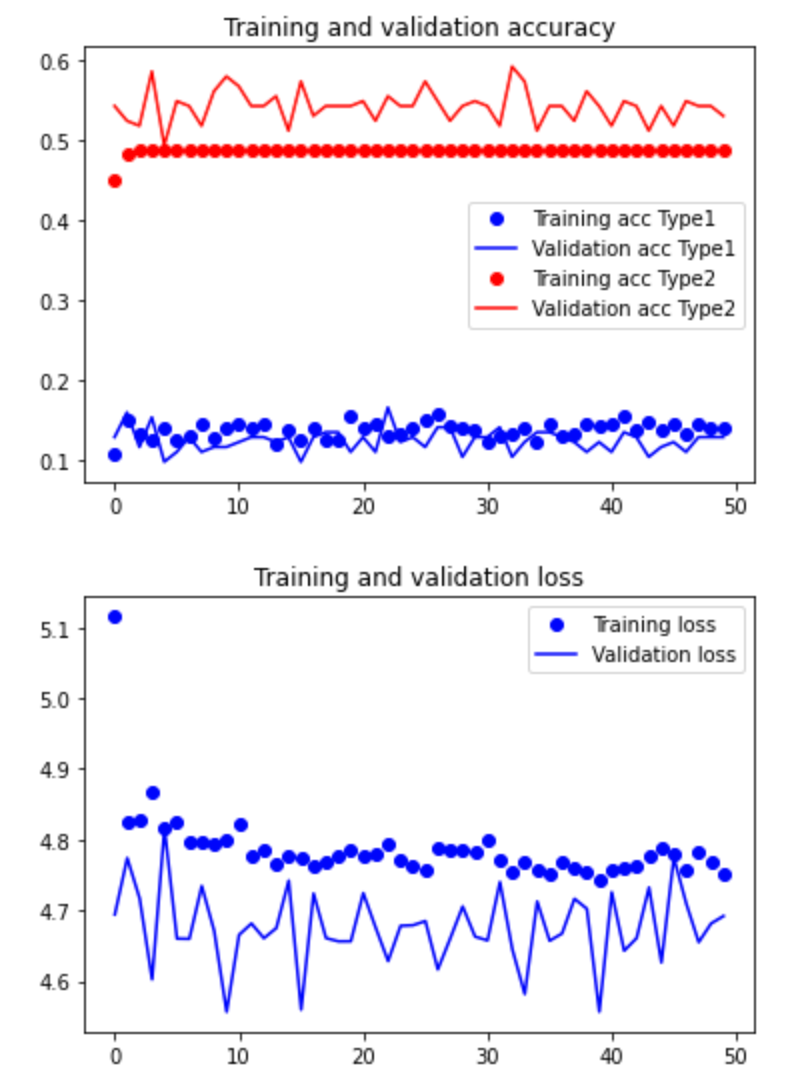

The model shows a higher accuracy for the Type 2 classification, which is the secondary type of Pokemon. This is due to the fact that not all Pokemon have a secondary Type, 404 of the 809 pokemon do not have a secondary type. Which menas that more Pokemon will have 'None' as classification. On the other hand, it can be seen that the accuracy for Type 1, the primary type, is still low, not even reaching 20%, meaning that it did worse than the general model. The loss was incredibly high, reaching values around 4, the individual losses being around a value of 2 for each task. The model seems like it will performe very poorly. 

In [ ]:
# Test model
MODEL_PATH='pokemon_model_11.h5'
TEST_IMAGE='rock.png'

# load the image
image = cv2.imread(TEST_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# pre-process the image for classification
image = cv2.resize(image, (150, 150))
image = image.astype("float") / 255.0
image = img_to_array(image)
plt.imshow(image)
image = np.expand_dims(image, axis=0)

# loading model
print("[INFO] loading network...")
model = load_model(MODEL_PATH)

# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
type1Proba, type2Proba = model.predict(image)
type1Idx = type1Proba[0].argmax()
type2Idx = type2Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]
type2LabelRes = type2LB.classes_[type2Idx]

print(f'Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n Type2: {type2LabelRes} Probability: {type2Proba[0][type2Idx] * 100:.2f}%')



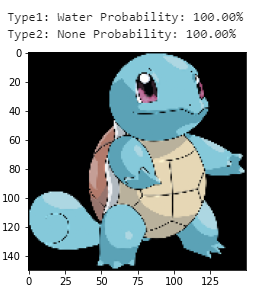
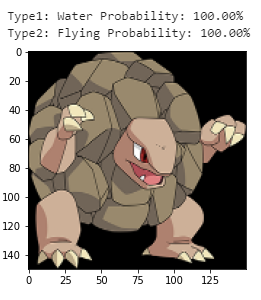
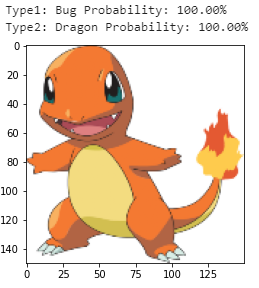
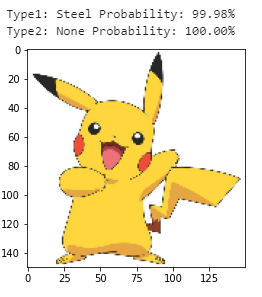

From the pokemon we used: 

- Squirtle is a primary water type and has no secondary type. 
- Golem is a primary rock type and secondary ground type. 
- Charmander is a fire primary type and has no secondary type. 
- Pikachu is a electric primary type with no secondary type.  

From the model predictions, Squirtless type was correctly predicted and Pikachu's secondary type was correctly predicted. From the rest, it did not predict correctly. The model did very poorly. 


## Second Multi-task

We will try a new approach to make a multi-task, comparing the performance of detailed vs. fine tasks. On this model we saw that there were only two tasks, with multiple classifications. On the new model, we set out to have 7 tasks, dedicated to each of the chosen pokemon types. We will again update the PokemonNet class to make the 7 branches. 

In [47]:
class PokemonNet2:
    
    @staticmethod
    def build_fire_branch(inputs, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="fire_output")(x)
        
        return x
        
    @staticmethod
    def build_water_branch(inputs, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="water_output")(x)
        
        return x
    
    @staticmethod
    def build_grass_branch(inputs, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="grass_output")(x)
        
        return x
    
    @staticmethod
    def build_normal_branch(inputs, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="normal_output")(x)
        
        return x
    
    @staticmethod
    def build_bug_branch(inputs, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="bug_output")(x)
        
        return x
    
    @staticmethod
    def build_rock_branch(inputs, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="rock_output")(x)
        
        return x
    
    @staticmethod
    def build_electric_branch(inputs, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation(finalAct, name="electric_output")(x)
        
        return x
    
    
    @staticmethod
    def build_model(width, height, finalAct="sigmoid"):
        
        inputs = Input(shape=(width, height, 3))

        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        
        # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        
        # Constructing 7 heads.
        fire_branch = PokemonNet2.build_fire_branch(x, finalAct)
        water_branch = PokemonNet2.build_water_branch(x, finalAct)
        grass_branch = PokemonNet2.build_grass_branch(x, finalAct)
        normal_branch = PokemonNet2.build_normal_branch(x, finalAct)
        bug_branch = PokemonNet2.build_bug_branch(x, finalAct)
        rock_branch = PokemonNet2.build_rock_branch(x, finalAct)
        electric_branch = PokemonNet2.build_electric_branch(x, finalAct)
        
        # Building the model
        print("Building model...")
        model = Model(
            inputs=inputs,
            outputs=[fire_branch, water_branch, grass_branch, normal_branch, bug_branch, rock_branch, electric_branch],
            name="pokemonnet2"
                     )
        
        return model    
    
    @staticmethod
    def net_generator(generator, data, label1, label2, batch_s):
        gen1 = generator.flow(data, label1, batch_size=batch_s)
        gen2 = generator.flow(data, label2, batch_size=batch_s)
        while True:
            X1 = gen1.next()
            X2 = gen2.next()
            yield X1[0], [X1[1], X2[1]] 
        
        

In [ ]:
EPOCHS = 50
BATCH_SIZE = 28
INIT_LR = 1e-3
IMG_DIMS = [150, 150]
ACTIVATION = 'sigmoid'


# Extracting images
data = load_images('images\images', IMG_DIMS)

# Values between [0, 1]
data = np.array(data, dtype='float')/255.0


# Creating labels for each type
fire_labels = label_dataset('Fire', 'pokemon_2.csv')
water_labels = label_dataset('Water', 'pokemon_2.csv')
grass_labels = label_dataset('Grass', 'pokemon_2.csv')
normal_labels = label_dataset('Normal', 'pokemon_2.csv')
bug_labels = label_dataset('Bug', 'pokemon_2.csv')
rock_labels = label_dataset('Rock', 'pokemon_2.csv')
electric_labels = label_dataset('Electric', 'pokemon_2.csv')


# Split data into training and validation
split = train_test_split(data, 
                         fire_labels,
                         water_labels,
                         grass_labels,
                         normal_labels,
                         bug_labels,
                         rock_labels, 
                         electric_labels,
                         test_size=0.2)

(trainX, 
 testX, 
 trainFireY, 
 testFireY, 
 trainWaterY, 
 testWaterY,
 trainGrassY,
 testGrassY,
 trainNormalY,
 testNormalY,
 trainBugY,
 testBugY,
 trainRockY,
 testRockY,
 trainElectricY,
 testElectricY) = split


# Creating model
model = PokemonNet2.build_model(IMG_DIMS[0], IMG_DIMS[1],
                               finalAct= ACTIVATION)

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

# Displaying model summary
model.summary()

# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

"""
# train the network to perform multi-output classification
H = model.fit(x=trainX, 
        y={"type1_classification": trainType1Y, "type2_classification": trainType2Y},
        validation_data=(testX, 
            {"type1_classification": testType1Y, "type2_classification": testType2Y}),
        steps_per_epoch=len(trainX)/BATCH_SIZE,
        validation_steps=len(testX)/BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1)
"""

# train the network to perform multi-output classification
H = model.fit(trainX, y={
    "fire_output": trainFireY,
    "water_output": trainWaterY,
    "grass_output": trainGrassY,
    "normal_output": trainNormalY,
    "bug_output": trainBugY,
    "rock_output": trainRockY,
    "electric_output": trainElectricY},
              validation_data= (testX, {
                  "fire_output": testFireY,
                  "water_output": testWaterY,
                    "grass_output": testGrassY,
                    "normal_output": testNormalY,
                    "bug_output": testBugY,
                    "rock_output": testRockY,
                    "electric_output": testElectricY
                  
              }),
              steps_per_epoch=len(trainX)/BATCH_SIZE,
              validation_steps=len(testX)/BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1)

In [ ]:
Building model...
Model: "pokemonnet2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 150, 150, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 50, 32)   0           activation[0][0]                 
__________________________________________________________________________________________________
dropout (Dropout)               (None, 50, 50, 32)   0           max_pooling2d[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 64)   18496       dropout[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 50, 50, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 50, 50, 64)   36928       activation_1[0][0]               
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 50, 50, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 25, 25, 64)   0           activation_2[0][0]               
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 25, 25, 64)   0           max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 25, 25, 128)  73856       dropout_1[0][0]                  
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 25, 25, 128)  0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 25, 25, 128)  147584      activation_3[0][0]               
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 25, 25, 128)  0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 128)  0           activation_4[0][0]               
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 12, 12, 128)  0           max_pooling2d_2[0][0]            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 18432)        0           dropout_2[0][0]                  
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 18432)        0           dropout_2[0][0]                  
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 18432)        0           dropout_2[0][0]                  
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 18432)        0           dropout_2[0][0]                  
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 18432)        0           dropout_2[0][0]                  
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 18432)        0           dropout_2[0][0]                  
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 18432)        0           dropout_2[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          4718848     flatten[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          4718848     flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 256)          4718848     flatten_2[0][0]                  
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 256)          4718848     flatten_3[0][0]                  
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 256)          4718848     flatten_4[0][0]                  
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 256)          4718848     flatten_5[0][0]                  
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 256)          4718848     flatten_6[0][0]                  
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 256)          0           dense[0][0]                      
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 256)          0           dense_2[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 256)          0           dense_4[0][0]                    
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 256)          0           dense_6[0][0]                    
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 256)          0           dense_8[0][0]                    
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 256)          0           dense_10[0][0]                   
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 256)          0           dense_12[0][0]                   
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 256)          0           activation_5[0][0]               
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 256)          0           activation_6[0][0]               
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 256)          0           activation_7[0][0]               
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 256)          0           activation_8[0][0]               
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 256)          0           activation_9[0][0]               
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 256)          0           activation_10[0][0]              
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256)          0           activation_11[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            257         dropout_3[0][0]                  
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1)            257         dropout_4[0][0]                  
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 1)            257         dropout_5[0][0]                  
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 1)            257         dropout_6[0][0]                  
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1)            257         dropout_7[0][0]                  
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 1)            257         dropout_8[0][0]                  
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 1)            257         dropout_9[0][0]                  
__________________________________________________________________________________________________
fire_output (Activation)        (None, 1)            0           dense_1[0][0]                    
__________________________________________________________________________________________________
water_output (Activation)       (None, 1)            0           dense_3[0][0]                    
__________________________________________________________________________________________________
grass_output (Activation)       (None, 1)            0           dense_5[0][0]                    
__________________________________________________________________________________________________
normal_output (Activation)      (None, 1)            0           dense_7[0][0]                    
__________________________________________________________________________________________________
bug_output (Activation)         (None, 1)            0           dense_9[0][0]                    
__________________________________________________________________________________________________
rock_output (Activation)        (None, 1)            0           dense_11[0][0]                   
__________________________________________________________________________________________________
electric_output (Activation)    (None, 1)            0           dense_13[0][0]                   
==================================================================================================
Total params: 33,311,495
Trainable params: 33,311,495
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/50
23/23 [==============================] - 13s 486ms/step - loss: 3.3036 - fire_output_loss: 0.4939 - water_output_loss: 0.5227 - grass_output_loss: 0.5684 - normal_output_loss: 0.5902 - bug_output_loss: 0.4090 - rock_output_loss: 0.3530 - electric_output_loss: 0.3663 - fire_output_accuracy: 0.8871 - water_output_accuracy: 0.7874 - grass_output_accuracy: 0.7991 - normal_output_accuracy: 0.8115 - bug_output_accuracy: 0.9039 - rock_output_accuracy: 0.8709 - electric_output_accuracy: 0.9168 - val_loss: 2.4605 - val_fire_output_loss: 0.2640 - val_water_output_loss: 0.4412 - val_grass_output_loss: 0.3767 - val_normal_output_loss: 0.4107 - val_bug_output_loss: 0.3677 - val_rock_output_loss: 0.3008 - val_electric_output_loss: 0.2994 - val_fire_output_accuracy: 0.9321 - val_water_output_accuracy: 0.8889 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 2/50
23/23 [==============================] - 10s 432ms/step - loss: 2.3977 - fire_output_loss: 0.2864 - water_output_loss: 0.5175 - grass_output_loss: 0.3686 - normal_output_loss: 0.4015 - bug_output_loss: 0.3259 - rock_output_loss: 0.2716 - electric_output_loss: 0.2263 - fire_output_accuracy: 0.9131 - water_output_accuracy: 0.8055 - grass_output_accuracy: 0.8815 - normal_output_accuracy: 0.8699 - bug_output_accuracy: 0.9043 - rock_output_accuracy: 0.9276 - electric_output_accuracy: 0.9455 - val_loss: 2.4348 - val_fire_output_loss: 0.2708 - val_water_output_loss: 0.3922 - val_grass_output_loss: 0.3952 - val_normal_output_loss: 0.4441 - val_bug_output_loss: 0.3588 - val_rock_output_loss: 0.3225 - val_electric_output_loss: 0.2513 - val_fire_output_accuracy: 0.9321 - val_water_output_accuracy: 0.8889 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 3/50
23/23 [==============================] - 10s 441ms/step - loss: 2.3172 - fire_output_loss: 0.2552 - water_output_loss: 0.4654 - grass_output_loss: 0.4341 - normal_output_loss: 0.3912 - bug_output_loss: 0.3057 - rock_output_loss: 0.2473 - electric_output_loss: 0.2183 - fire_output_accuracy: 0.9282 - water_output_accuracy: 0.8333 - grass_output_accuracy: 0.8580 - normal_output_accuracy: 0.8835 - bug_output_accuracy: 0.9116 - rock_output_accuracy: 0.9363 - electric_output_accuracy: 0.9426 - val_loss: 2.4263 - val_fire_output_loss: 0.2888 - val_water_output_loss: 0.4232 - val_grass_output_loss: 0.3790 - val_normal_output_loss: 0.4261 - val_bug_output_loss: 0.3463 - val_rock_output_loss: 0.3239 - val_electric_output_loss: 0.2391 - val_fire_output_accuracy: 0.9321 - val_water_output_accuracy: 0.8889 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 4/50
23/23 [==============================] - 11s 473ms/step - loss: 2.2901 - fire_output_loss: 0.2561 - water_output_loss: 0.4620 - grass_output_loss: 0.3797 - normal_output_loss: 0.3986 - bug_output_loss: 0.3176 - rock_output_loss: 0.2591 - electric_output_loss: 0.2169 - fire_output_accuracy: 0.9286 - water_output_accuracy: 0.8428 - grass_output_accuracy: 0.8715 - normal_output_accuracy: 0.8663 - bug_output_accuracy: 0.9031 - rock_output_accuracy: 0.9406 - electric_output_accuracy: 0.9448 - val_loss: 2.2333 - val_fire_output_loss: 0.2452 - val_water_output_loss: 0.3700 - val_grass_output_loss: 0.3713 - val_normal_output_loss: 0.4051 - val_bug_output_loss: 0.3264 - val_rock_output_loss: 0.2957 - val_electric_output_loss: 0.2197 - val_fire_output_accuracy: 0.9321 - val_water_output_accuracy: 0.8889 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 5/50
23/23 [==============================] - 11s 471ms/step - loss: 2.1921 - fire_output_loss: 0.2814 - water_output_loss: 0.4831 - grass_output_loss: 0.3218 - normal_output_loss: 0.3620 - bug_output_loss: 0.2898 - rock_output_loss: 0.2233 - electric_output_loss: 0.2308 - fire_output_accuracy: 0.9125 - water_output_accuracy: 0.8161 - grass_output_accuracy: 0.8972 - normal_output_accuracy: 0.8792 - bug_output_accuracy: 0.9155 - rock_output_accuracy: 0.9427 - electric_output_accuracy: 0.9390 - val_loss: 2.1971 - val_fire_output_loss: 0.2280 - val_water_output_loss: 0.3506 - val_grass_output_loss: 0.3570 - val_normal_output_loss: 0.4099 - val_bug_output_loss: 0.3231 - val_rock_output_loss: 0.3022 - val_electric_output_loss: 0.2263 - val_fire_output_accuracy: 0.9321 - val_water_output_accuracy: 0.8889 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 6/50
23/23 [==============================] - 11s 473ms/step - loss: 2.3604 - fire_output_loss: 0.2594 - water_output_loss: 0.5365 - grass_output_loss: 0.3220 - normal_output_loss: 0.3695 - bug_output_loss: 0.3330 - rock_output_loss: 0.2818 - electric_output_loss: 0.2583 - fire_output_accuracy: 0.9219 - water_output_accuracy: 0.8034 - grass_output_accuracy: 0.8922 - normal_output_accuracy: 0.8749 - bug_output_accuracy: 0.9027 - rock_output_accuracy: 0.9220 - electric_output_accuracy: 0.9348 - val_loss: 2.1842 - val_fire_output_loss: 0.2273 - val_water_output_loss: 0.3525 - val_grass_output_loss: 0.3567 - val_normal_output_loss: 0.4059 - val_bug_output_loss: 0.3170 - val_rock_output_loss: 0.3038 - val_electric_output_loss: 0.2209 - val_fire_output_accuracy: 0.9321 - val_water_output_accuracy: 0.8889 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 7/50
23/23 [==============================] - 11s 481ms/step - loss: 2.1685 - fire_output_loss: 0.2198 - water_output_loss: 0.4599 - grass_output_loss: 0.3535 - normal_output_loss: 0.3985 - bug_output_loss: 0.2835 - rock_output_loss: 0.2239 - electric_output_loss: 0.2295 - fire_output_accuracy: 0.9233 - water_output_accuracy: 0.8054 - grass_output_accuracy: 0.8680 - normal_output_accuracy: 0.8581 - bug_output_accuracy: 0.9145 - rock_output_accuracy: 0.9374 - electric_output_accuracy: 0.9422 - val_loss: 2.3385 - val_fire_output_loss: 0.3335 - val_water_output_loss: 0.3324 - val_grass_output_loss: 0.3860 - val_normal_output_loss: 0.4186 - val_bug_output_loss: 0.3334 - val_rock_output_loss: 0.2963 - val_electric_output_loss: 0.2383 - val_fire_output_accuracy: 0.9321 - val_water_output_accuracy: 0.8889 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 8/50
23/23 [==============================] - 11s 479ms/step - loss: 2.1803 - fire_output_loss: 0.2597 - water_output_loss: 0.4282 - grass_output_loss: 0.3464 - normal_output_loss: 0.3765 - bug_output_loss: 0.2867 - rock_output_loss: 0.2419 - electric_output_loss: 0.2409 - fire_output_accuracy: 0.9186 - water_output_accuracy: 0.8225 - grass_output_accuracy: 0.8894 - normal_output_accuracy: 0.8590 - bug_output_accuracy: 0.9051 - rock_output_accuracy: 0.9276 - electric_output_accuracy: 0.9315 - val_loss: 2.2584 - val_fire_output_loss: 0.2592 - val_water_output_loss: 0.3393 - val_grass_output_loss: 0.3789 - val_normal_output_loss: 0.4160 - val_bug_output_loss: 0.3319 - val_rock_output_loss: 0.3020 - val_electric_output_loss: 0.2311 - val_fire_output_accuracy: 0.9321 - val_water_output_accuracy: 0.8889 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 9/50
23/23 [==============================] - 11s 476ms/step - loss: 2.0603 - fire_output_loss: 0.2182 - water_output_loss: 0.4425 - grass_output_loss: 0.2836 - normal_output_loss: 0.3548 - bug_output_loss: 0.2807 - rock_output_loss: 0.2395 - electric_output_loss: 0.2409 - fire_output_accuracy: 0.9146 - water_output_accuracy: 0.8144 - grass_output_accuracy: 0.9059 - normal_output_accuracy: 0.8692 - bug_output_accuracy: 0.9113 - rock_output_accuracy: 0.9241 - electric_output_accuracy: 0.9226 - val_loss: 2.2681 - val_fire_output_loss: 0.2604 - val_water_output_loss: 0.3464 - val_grass_output_loss: 0.4049 - val_normal_output_loss: 0.4176 - val_bug_output_loss: 0.3251 - val_rock_output_loss: 0.2913 - val_electric_output_loss: 0.2223 - val_fire_output_accuracy: 0.9321 - val_water_output_accuracy: 0.8889 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 10/50
23/23 [==============================] - 11s 459ms/step - loss: 2.0040 - fire_output_loss: 0.1926 - water_output_loss: 0.4282 - grass_output_loss: 0.3309 - normal_output_loss: 0.3403 - bug_output_loss: 0.2679 - rock_output_loss: 0.2485 - electric_output_loss: 0.1955 - fire_output_accuracy: 0.9337 - water_output_accuracy: 0.8062 - grass_output_accuracy: 0.8771 - normal_output_accuracy: 0.8711 - bug_output_accuracy: 0.8982 - rock_output_accuracy: 0.9158 - electric_output_accuracy: 0.9424 - val_loss: 2.2519 - val_fire_output_loss: 0.2692 - val_water_output_loss: 0.3283 - val_grass_output_loss: 0.3420 - val_normal_output_loss: 0.4063 - val_bug_output_loss: 0.3413 - val_rock_output_loss: 0.3482 - val_electric_output_loss: 0.2167 - val_fire_output_accuracy: 0.9259 - val_water_output_accuracy: 0.8889 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 11/50
23/23 [==============================] - 10s 454ms/step - loss: 1.8128 - fire_output_loss: 0.1839 - water_output_loss: 0.3650 - grass_output_loss: 0.2865 - normal_output_loss: 0.3552 - bug_output_loss: 0.2837 - rock_output_loss: 0.1983 - electric_output_loss: 0.1403 - fire_output_accuracy: 0.9397 - water_output_accuracy: 0.8500 - grass_output_accuracy: 0.8825 - normal_output_accuracy: 0.8563 - bug_output_accuracy: 0.8954 - rock_output_accuracy: 0.9303 - electric_output_accuracy: 0.9541 - val_loss: 2.2689 - val_fire_output_loss: 0.2598 - val_water_output_loss: 0.3513 - val_grass_output_loss: 0.3615 - val_normal_output_loss: 0.4012 - val_bug_output_loss: 0.3355 - val_rock_output_loss: 0.3341 - val_electric_output_loss: 0.2255 - val_fire_output_accuracy: 0.9321 - val_water_output_accuracy: 0.8889 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 12/50
23/23 [==============================] - 11s 465ms/step - loss: 1.7346 - fire_output_loss: 0.1522 - water_output_loss: 0.3401 - grass_output_loss: 0.2969 - normal_output_loss: 0.3212 - bug_output_loss: 0.2435 - rock_output_loss: 0.1957 - electric_output_loss: 0.1849 - fire_output_accuracy: 0.9489 - water_output_accuracy: 0.8497 - grass_output_accuracy: 0.8703 - normal_output_accuracy: 0.8577 - bug_output_accuracy: 0.8985 - rock_output_accuracy: 0.9333 - electric_output_accuracy: 0.9401 - val_loss: 2.5009 - val_fire_output_loss: 0.3044 - val_water_output_loss: 0.3563 - val_grass_output_loss: 0.4175 - val_normal_output_loss: 0.4336 - val_bug_output_loss: 0.3845 - val_rock_output_loss: 0.3547 - val_electric_output_loss: 0.2499 - val_fire_output_accuracy: 0.9321 - val_water_output_accuracy: 0.8889 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 13/50
23/23 [==============================] - 11s 459ms/step - loss: 1.6318 - fire_output_loss: 0.1749 - water_output_loss: 0.3112 - grass_output_loss: 0.2757 - normal_output_loss: 0.3008 - bug_output_loss: 0.1957 - rock_output_loss: 0.1803 - electric_output_loss: 0.1932 - fire_output_accuracy: 0.9319 - water_output_accuracy: 0.8843 - grass_output_accuracy: 0.8884 - normal_output_accuracy: 0.8639 - bug_output_accuracy: 0.9174 - rock_output_accuracy: 0.9389 - electric_output_accuracy: 0.9328 - val_loss: 2.4122 - val_fire_output_loss: 0.3052 - val_water_output_loss: 0.3486 - val_grass_output_loss: 0.3427 - val_normal_output_loss: 0.4235 - val_bug_output_loss: 0.3777 - val_rock_output_loss: 0.3749 - val_electric_output_loss: 0.2395 - val_fire_output_accuracy: 0.8827 - val_water_output_accuracy: 0.8642 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8889 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 14/50
23/23 [==============================] - 11s 459ms/step - loss: 1.4794 - fire_output_loss: 0.1471 - water_output_loss: 0.2893 - grass_output_loss: 0.2189 - normal_output_loss: 0.2955 - bug_output_loss: 0.1875 - rock_output_loss: 0.2101 - electric_output_loss: 0.1310 - fire_output_accuracy: 0.9518 - water_output_accuracy: 0.8748 - grass_output_accuracy: 0.9002 - normal_output_accuracy: 0.8574 - bug_output_accuracy: 0.9207 - rock_output_accuracy: 0.9177 - electric_output_accuracy: 0.9479 - val_loss: 2.6030 - val_fire_output_loss: 0.3074 - val_water_output_loss: 0.3661 - val_grass_output_loss: 0.3644 - val_normal_output_loss: 0.4507 - val_bug_output_loss: 0.4253 - val_rock_output_loss: 0.4463 - val_electric_output_loss: 0.2428 - val_fire_output_accuracy: 0.8827 - val_water_output_accuracy: 0.8889 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8889 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 15/50
23/23 [==============================] - 11s 463ms/step - loss: 1.3866 - fire_output_loss: 0.1647 - water_output_loss: 0.2765 - grass_output_loss: 0.2409 - normal_output_loss: 0.2437 - bug_output_loss: 0.2097 - rock_output_loss: 0.1572 - electric_output_loss: 0.0939 - fire_output_accuracy: 0.9280 - water_output_accuracy: 0.8851 - grass_output_accuracy: 0.8762 - normal_output_accuracy: 0.8803 - bug_output_accuracy: 0.9057 - rock_output_accuracy: 0.9426 - electric_output_accuracy: 0.9586 - val_loss: 2.7311 - val_fire_output_loss: 0.3310 - val_water_output_loss: 0.3530 - val_grass_output_loss: 0.3750 - val_normal_output_loss: 0.4850 - val_bug_output_loss: 0.4496 - val_rock_output_loss: 0.4676 - val_electric_output_loss: 0.2698 - val_fire_output_accuracy: 0.8704 - val_water_output_accuracy: 0.8395 - val_grass_output_accuracy: 0.8642 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8889 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 16/50
23/23 [==============================] - 11s 466ms/step - loss: 1.2820 - fire_output_loss: 0.1214 - water_output_loss: 0.2557 - grass_output_loss: 0.2199 - normal_output_loss: 0.2589 - bug_output_loss: 0.1810 - rock_output_loss: 0.1473 - electric_output_loss: 0.0978 - fire_output_accuracy: 0.9492 - water_output_accuracy: 0.9110 - grass_output_accuracy: 0.8904 - normal_output_accuracy: 0.8740 - bug_output_accuracy: 0.9186 - rock_output_accuracy: 0.9371 - electric_output_accuracy: 0.9577 - val_loss: 3.1953 - val_fire_output_loss: 0.4898 - val_water_output_loss: 0.3816 - val_grass_output_loss: 0.4318 - val_normal_output_loss: 0.5765 - val_bug_output_loss: 0.4985 - val_rock_output_loss: 0.5223 - val_electric_output_loss: 0.2948 - val_fire_output_accuracy: 0.9321 - val_water_output_accuracy: 0.8457 - val_grass_output_accuracy: 0.8580 - val_normal_output_accuracy: 0.8642 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 17/50
23/23 [==============================] - 11s 469ms/step - loss: 1.1471 - fire_output_loss: 0.1129 - water_output_loss: 0.2229 - grass_output_loss: 0.1982 - normal_output_loss: 0.2391 - bug_output_loss: 0.1586 - rock_output_loss: 0.1260 - electric_output_loss: 0.0893 - fire_output_accuracy: 0.9383 - water_output_accuracy: 0.9022 - grass_output_accuracy: 0.8962 - normal_output_accuracy: 0.9058 - bug_output_accuracy: 0.9292 - rock_output_accuracy: 0.9415 - electric_output_accuracy: 0.9604 - val_loss: 3.3899 - val_fire_output_loss: 0.4392 - val_water_output_loss: 0.4429 - val_grass_output_loss: 0.4836 - val_normal_output_loss: 0.6049 - val_bug_output_loss: 0.5213 - val_rock_output_loss: 0.5834 - val_electric_output_loss: 0.3144 - val_fire_output_accuracy: 0.8951 - val_water_output_accuracy: 0.8580 - val_grass_output_accuracy: 0.8580 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.8951 - val_electric_output_accuracy: 0.9444
Epoch 18/50
23/23 [==============================] - 11s 465ms/step - loss: 1.0639 - fire_output_loss: 0.0869 - water_output_loss: 0.2321 - grass_output_loss: 0.1933 - normal_output_loss: 0.2223 - bug_output_loss: 0.1600 - rock_output_loss: 0.0878 - electric_output_loss: 0.0813 - fire_output_accuracy: 0.9691 - water_output_accuracy: 0.9007 - grass_output_accuracy: 0.9049 - normal_output_accuracy: 0.8863 - bug_output_accuracy: 0.9359 - rock_output_accuracy: 0.9635 - electric_output_accuracy: 0.9689 - val_loss: 3.2381 - val_fire_output_loss: 0.4104 - val_water_output_loss: 0.4165 - val_grass_output_loss: 0.4092 - val_normal_output_loss: 0.6175 - val_bug_output_loss: 0.4720 - val_rock_output_loss: 0.5891 - val_electric_output_loss: 0.3234 - val_fire_output_accuracy: 0.8951 - val_water_output_accuracy: 0.8642 - val_grass_output_accuracy: 0.8580 - val_normal_output_accuracy: 0.8519 - val_bug_output_accuracy: 0.8889 - val_rock_output_accuracy: 0.8827 - val_electric_output_accuracy: 0.9444
Epoch 19/50
23/23 [==============================] - 11s 470ms/step - loss: 0.9729 - fire_output_loss: 0.1047 - water_output_loss: 0.2020 - grass_output_loss: 0.1825 - normal_output_loss: 0.1918 - bug_output_loss: 0.1315 - rock_output_loss: 0.0999 - electric_output_loss: 0.0605 - fire_output_accuracy: 0.9644 - water_output_accuracy: 0.9229 - grass_output_accuracy: 0.9129 - normal_output_accuracy: 0.9163 - bug_output_accuracy: 0.9529 - rock_output_accuracy: 0.9586 - electric_output_accuracy: 0.9774 - val_loss: 3.9571 - val_fire_output_loss: 0.4759 - val_water_output_loss: 0.5427 - val_grass_output_loss: 0.5098 - val_normal_output_loss: 0.6272 - val_bug_output_loss: 0.5583 - val_rock_output_loss: 0.8600 - val_electric_output_loss: 0.3832 - val_fire_output_accuracy: 0.8889 - val_water_output_accuracy: 0.8765 - val_grass_output_accuracy: 0.8580 - val_normal_output_accuracy: 0.8519 - val_bug_output_accuracy: 0.8889 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9444
Epoch 20/50
23/23 [==============================] - 11s 467ms/step - loss: 0.8389 - fire_output_loss: 0.0620 - water_output_loss: 0.1716 - grass_output_loss: 0.1475 - normal_output_loss: 0.1594 - bug_output_loss: 0.1321 - rock_output_loss: 0.1125 - electric_output_loss: 0.0540 - fire_output_accuracy: 0.9795 - water_output_accuracy: 0.9366 - grass_output_accuracy: 0.9297 - normal_output_accuracy: 0.9419 - bug_output_accuracy: 0.9335 - rock_output_accuracy: 0.9528 - electric_output_accuracy: 0.9807 - val_loss: 4.3113 - val_fire_output_loss: 0.5904 - val_water_output_loss: 0.5160 - val_grass_output_loss: 0.5321 - val_normal_output_loss: 0.7702 - val_bug_output_loss: 0.6042 - val_rock_output_loss: 0.8401 - val_electric_output_loss: 0.4583 - val_fire_output_accuracy: 0.9198 - val_water_output_accuracy: 0.8395 - val_grass_output_accuracy: 0.8580 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.8889 - val_electric_output_accuracy: 0.9383
Epoch 21/50
23/23 [==============================] - 11s 468ms/step - loss: 0.7274 - fire_output_loss: 0.0789 - water_output_loss: 0.1553 - grass_output_loss: 0.1129 - normal_output_loss: 0.1463 - bug_output_loss: 0.0937 - rock_output_loss: 0.0811 - electric_output_loss: 0.0593 - fire_output_accuracy: 0.9636 - water_output_accuracy: 0.9399 - grass_output_accuracy: 0.9431 - normal_output_accuracy: 0.9346 - bug_output_accuracy: 0.9550 - rock_output_accuracy: 0.9687 - electric_output_accuracy: 0.9753 - val_loss: 4.9225 - val_fire_output_loss: 0.7818 - val_water_output_loss: 0.5774 - val_grass_output_loss: 0.5585 - val_normal_output_loss: 0.8351 - val_bug_output_loss: 0.7080 - val_rock_output_loss: 0.9195 - val_electric_output_loss: 0.5422 - val_fire_output_accuracy: 0.9198 - val_water_output_accuracy: 0.8580 - val_grass_output_accuracy: 0.8580 - val_normal_output_accuracy: 0.8457 - val_bug_output_accuracy: 0.9012 - val_rock_output_accuracy: 0.8827 - val_electric_output_accuracy: 0.9321
Epoch 22/50
23/23 [==============================] - 11s 457ms/step - loss: 0.6211 - fire_output_loss: 0.0657 - water_output_loss: 0.1086 - grass_output_loss: 0.1047 - normal_output_loss: 0.1118 - bug_output_loss: 0.0968 - rock_output_loss: 0.0780 - electric_output_loss: 0.0555 - fire_output_accuracy: 0.9635 - water_output_accuracy: 0.9532 - grass_output_accuracy: 0.9590 - normal_output_accuracy: 0.9515 - bug_output_accuracy: 0.9556 - rock_output_accuracy: 0.9680 - electric_output_accuracy: 0.9759 - val_loss: 5.2374 - val_fire_output_loss: 0.6640 - val_water_output_loss: 0.6467 - val_grass_output_loss: 0.6009 - val_normal_output_loss: 0.9161 - val_bug_output_loss: 0.7466 - val_rock_output_loss: 1.0879 - val_electric_output_loss: 0.5751 - val_fire_output_accuracy: 0.8951 - val_water_output_accuracy: 0.8272 - val_grass_output_accuracy: 0.8457 - val_normal_output_accuracy: 0.8580 - val_bug_output_accuracy: 0.8827 - val_rock_output_accuracy: 0.8951 - val_electric_output_accuracy: 0.9383
Epoch 23/50
23/23 [==============================] - 11s 462ms/step - loss: 0.6021 - fire_output_loss: 0.0559 - water_output_loss: 0.1019 - grass_output_loss: 0.0980 - normal_output_loss: 0.1208 - bug_output_loss: 0.0949 - rock_output_loss: 0.0755 - electric_output_loss: 0.0550 - fire_output_accuracy: 0.9757 - water_output_accuracy: 0.9675 - grass_output_accuracy: 0.9586 - normal_output_accuracy: 0.9442 - bug_output_accuracy: 0.9549 - rock_output_accuracy: 0.9732 - electric_output_accuracy: 0.9733 - val_loss: 5.9902 - val_fire_output_loss: 0.8055 - val_water_output_loss: 0.7204 - val_grass_output_loss: 0.6529 - val_normal_output_loss: 1.1655 - val_bug_output_loss: 0.8467 - val_rock_output_loss: 1.1962 - val_electric_output_loss: 0.6029 - val_fire_output_accuracy: 0.9012 - val_water_output_accuracy: 0.8272 - val_grass_output_accuracy: 0.8519 - val_normal_output_accuracy: 0.8519 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.9074 - val_electric_output_accuracy: 0.9259
Epoch 24/50
23/23 [==============================] - 11s 463ms/step - loss: 0.5282 - fire_output_loss: 0.0568 - water_output_loss: 0.0964 - grass_output_loss: 0.0758 - normal_output_loss: 0.1115 - bug_output_loss: 0.0843 - rock_output_loss: 0.0602 - electric_output_loss: 0.0431 - fire_output_accuracy: 0.9741 - water_output_accuracy: 0.9585 - grass_output_accuracy: 0.9673 - normal_output_accuracy: 0.9504 - bug_output_accuracy: 0.9647 - rock_output_accuracy: 0.9743 - electric_output_accuracy: 0.9810 - val_loss: 6.8757 - val_fire_output_loss: 1.0101 - val_water_output_loss: 0.7707 - val_grass_output_loss: 0.6719 - val_normal_output_loss: 1.2718 - val_bug_output_loss: 0.9625 - val_rock_output_loss: 1.5088 - val_electric_output_loss: 0.6799 - val_fire_output_accuracy: 0.9198 - val_water_output_accuracy: 0.8395 - val_grass_output_accuracy: 0.8457 - val_normal_output_accuracy: 0.8333 - val_bug_output_accuracy: 0.9012 - val_rock_output_accuracy: 0.9136 - val_electric_output_accuracy: 0.9321
Epoch 25/50
23/23 [==============================] - 11s 476ms/step - loss: 0.5006 - fire_output_loss: 0.0544 - water_output_loss: 0.0917 - grass_output_loss: 0.0948 - normal_output_loss: 0.0880 - bug_output_loss: 0.0645 - rock_output_loss: 0.0510 - electric_output_loss: 0.0561 - fire_output_accuracy: 0.9809 - water_output_accuracy: 0.9641 - grass_output_accuracy: 0.9641 - normal_output_accuracy: 0.9625 - bug_output_accuracy: 0.9784 - rock_output_accuracy: 0.9722 - electric_output_accuracy: 0.9818 - val_loss: 6.1588 - val_fire_output_loss: 0.8812 - val_water_output_loss: 0.7082 - val_grass_output_loss: 0.6655 - val_normal_output_loss: 1.0564 - val_bug_output_loss: 0.8383 - val_rock_output_loss: 1.3580 - val_electric_output_loss: 0.6512 - val_fire_output_accuracy: 0.9136 - val_water_output_accuracy: 0.8333 - val_grass_output_accuracy: 0.8395 - val_normal_output_accuracy: 0.8272 - val_bug_output_accuracy: 0.8765 - val_rock_output_accuracy: 0.8889 - val_electric_output_accuracy: 0.9259
Epoch 26/50
23/23 [==============================] - 11s 479ms/step - loss: 0.4120 - fire_output_loss: 0.0324 - water_output_loss: 0.0840 - grass_output_loss: 0.0650 - normal_output_loss: 0.0708 - bug_output_loss: 0.0582 - rock_output_loss: 0.0627 - electric_output_loss: 0.0390 - fire_output_accuracy: 0.9914 - water_output_accuracy: 0.9656 - grass_output_accuracy: 0.9797 - normal_output_accuracy: 0.9723 - bug_output_accuracy: 0.9790 - rock_output_accuracy: 0.9766 - electric_output_accuracy: 0.9919 - val_loss: 7.3227 - val_fire_output_loss: 1.1153 - val_water_output_loss: 0.8735 - val_grass_output_loss: 0.8029 - val_normal_output_loss: 1.2835 - val_bug_output_loss: 1.0033 - val_rock_output_loss: 1.5133 - val_electric_output_loss: 0.7310 - val_fire_output_accuracy: 0.9136 - val_water_output_accuracy: 0.8457 - val_grass_output_accuracy: 0.8333 - val_normal_output_accuracy: 0.8272 - val_bug_output_accuracy: 0.9012 - val_rock_output_accuracy: 0.8765 - val_electric_output_accuracy: 0.9259
Epoch 27/50
23/23 [==============================] - 11s 483ms/step - loss: 0.3688 - fire_output_loss: 0.0534 - water_output_loss: 0.0734 - grass_output_loss: 0.0471 - normal_output_loss: 0.0637 - bug_output_loss: 0.0502 - rock_output_loss: 0.0490 - electric_output_loss: 0.0320 - fire_output_accuracy: 0.9784 - water_output_accuracy: 0.9687 - grass_output_accuracy: 0.9828 - normal_output_accuracy: 0.9707 - bug_output_accuracy: 0.9772 - rock_output_accuracy: 0.9769 - electric_output_accuracy: 0.9855 - val_loss: 8.0201 - val_fire_output_loss: 0.9264 - val_water_output_loss: 1.0247 - val_grass_output_loss: 0.8954 - val_normal_output_loss: 1.4313 - val_bug_output_loss: 1.0840 - val_rock_output_loss: 1.7861 - val_electric_output_loss: 0.8721 - val_fire_output_accuracy: 0.9074 - val_water_output_accuracy: 0.8395 - val_grass_output_accuracy: 0.8765 - val_normal_output_accuracy: 0.8210 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.8827 - val_electric_output_accuracy: 0.9321
Epoch 28/50
23/23 [==============================] - 11s 484ms/step - loss: 0.4033 - fire_output_loss: 0.0426 - water_output_loss: 0.0559 - grass_output_loss: 0.0759 - normal_output_loss: 0.0793 - bug_output_loss: 0.0653 - rock_output_loss: 0.0521 - electric_output_loss: 0.0322 - fire_output_accuracy: 0.9812 - water_output_accuracy: 0.9758 - grass_output_accuracy: 0.9614 - normal_output_accuracy: 0.9682 - bug_output_accuracy: 0.9725 - rock_output_accuracy: 0.9687 - electric_output_accuracy: 0.9846 - val_loss: 7.7466 - val_fire_output_loss: 1.0331 - val_water_output_loss: 0.9631 - val_grass_output_loss: 0.8787 - val_normal_output_loss: 1.4106 - val_bug_output_loss: 1.0483 - val_rock_output_loss: 1.6196 - val_electric_output_loss: 0.7931 - val_fire_output_accuracy: 0.9136 - val_water_output_accuracy: 0.8519 - val_grass_output_accuracy: 0.8457 - val_normal_output_accuracy: 0.8086 - val_bug_output_accuracy: 0.8765 - val_rock_output_accuracy: 0.8827 - val_electric_output_accuracy: 0.9259
Epoch 29/50
23/23 [==============================] - 11s 482ms/step - loss: 0.3091 - fire_output_loss: 0.0247 - water_output_loss: 0.0567 - grass_output_loss: 0.0462 - normal_output_loss: 0.0827 - bug_output_loss: 0.0463 - rock_output_loss: 0.0318 - electric_output_loss: 0.0207 - fire_output_accuracy: 0.9821 - water_output_accuracy: 0.9825 - grass_output_accuracy: 0.9811 - normal_output_accuracy: 0.9618 - bug_output_accuracy: 0.9845 - rock_output_accuracy: 0.9808 - electric_output_accuracy: 0.9971 - val_loss: 8.9927 - val_fire_output_loss: 1.3354 - val_water_output_loss: 1.0071 - val_grass_output_loss: 1.0199 - val_normal_output_loss: 1.4944 - val_bug_output_loss: 1.1816 - val_rock_output_loss: 1.8721 - val_electric_output_loss: 1.0822 - val_fire_output_accuracy: 0.9074 - val_water_output_accuracy: 0.8333 - val_grass_output_accuracy: 0.8580 - val_normal_output_accuracy: 0.7963 - val_bug_output_accuracy: 0.9012 - val_rock_output_accuracy: 0.8889 - val_electric_output_accuracy: 0.9321
Epoch 30/50
23/23 [==============================] - 11s 481ms/step - loss: 0.3298 - fire_output_loss: 0.0332 - water_output_loss: 0.0473 - grass_output_loss: 0.0696 - normal_output_loss: 0.0509 - bug_output_loss: 0.0359 - rock_output_loss: 0.0398 - electric_output_loss: 0.0531 - fire_output_accuracy: 0.9938 - water_output_accuracy: 0.9855 - grass_output_accuracy: 0.9682 - normal_output_accuracy: 0.9800 - bug_output_accuracy: 0.9893 - rock_output_accuracy: 0.9730 - electric_output_accuracy: 0.9855 - val_loss: 7.8447 - val_fire_output_loss: 1.1855 - val_water_output_loss: 0.9228 - val_grass_output_loss: 0.7457 - val_normal_output_loss: 1.3913 - val_bug_output_loss: 1.1741 - val_rock_output_loss: 1.6150 - val_electric_output_loss: 0.8102 - val_fire_output_accuracy: 0.9136 - val_water_output_accuracy: 0.8333 - val_grass_output_accuracy: 0.8519 - val_normal_output_accuracy: 0.8148 - val_bug_output_accuracy: 0.8951 - val_rock_output_accuracy: 0.8704 - val_electric_output_accuracy: 0.9136
Epoch 31/50
23/23 [==============================] - 11s 474ms/step - loss: 0.3054 - fire_output_loss: 0.0202 - water_output_loss: 0.0572 - grass_output_loss: 0.0599 - normal_output_loss: 0.0499 - bug_output_loss: 0.0489 - rock_output_loss: 0.0409 - electric_output_loss: 0.0285 - fire_output_accuracy: 0.9952 - water_output_accuracy: 0.9802 - grass_output_accuracy: 0.9843 - normal_output_accuracy: 0.9897 - bug_output_accuracy: 0.9725 - rock_output_accuracy: 0.9860 - electric_output_accuracy: 0.9908 - val_loss: 8.7950 - val_fire_output_loss: 1.1366 - val_water_output_loss: 1.2344 - val_grass_output_loss: 0.8814 - val_normal_output_loss: 1.5630 - val_bug_output_loss: 1.1614 - val_rock_output_loss: 1.8406 - val_electric_output_loss: 0.9776 - val_fire_output_accuracy: 0.8889 - val_water_output_accuracy: 0.8580 - val_grass_output_accuracy: 0.8148 - val_normal_output_accuracy: 0.8272 - val_bug_output_accuracy: 0.8889 - val_rock_output_accuracy: 0.8827 - val_electric_output_accuracy: 0.9198
Epoch 32/50
23/23 [==============================] - 11s 478ms/step - loss: 0.2191 - fire_output_loss: 0.0286 - water_output_loss: 0.0510 - grass_output_loss: 0.0378 - normal_output_loss: 0.0324 - bug_output_loss: 0.0265 - rock_output_loss: 0.0327 - electric_output_loss: 0.0101 - fire_output_accuracy: 0.9917 - water_output_accuracy: 0.9741 - grass_output_accuracy: 0.9851 - normal_output_accuracy: 0.9896 - bug_output_accuracy: 0.9917 - rock_output_accuracy: 0.9846 - electric_output_accuracy: 0.9981 - val_loss: 10.4093 - val_fire_output_loss: 1.2050 - val_water_output_loss: 1.3625 - val_grass_output_loss: 1.0505 - val_normal_output_loss: 1.9907 - val_bug_output_loss: 1.3026 - val_rock_output_loss: 2.4288 - val_electric_output_loss: 1.0692 - val_fire_output_accuracy: 0.9074 - val_water_output_accuracy: 0.8395 - val_grass_output_accuracy: 0.8333 - val_normal_output_accuracy: 0.8457 - val_bug_output_accuracy: 0.8827 - val_rock_output_accuracy: 0.9012 - val_electric_output_accuracy: 0.9012
Epoch 33/50
23/23 [==============================] - 11s 480ms/step - loss: 0.1791 - fire_output_loss: 0.0122 - water_output_loss: 0.0429 - grass_output_loss: 0.0281 - normal_output_loss: 0.0218 - bug_output_loss: 0.0340 - rock_output_loss: 0.0249 - electric_output_loss: 0.0152 - fire_output_accuracy: 0.9972 - water_output_accuracy: 0.9877 - grass_output_accuracy: 0.9815 - normal_output_accuracy: 0.9963 - bug_output_accuracy: 0.9794 - rock_output_accuracy: 0.9903 - electric_output_accuracy: 0.9940 - val_loss: 12.1729 - val_fire_output_loss: 1.6898 - val_water_output_loss: 1.5434 - val_grass_output_loss: 1.3630 - val_normal_output_loss: 2.3321 - val_bug_output_loss: 1.6912 - val_rock_output_loss: 2.3487 - val_electric_output_loss: 1.2048 - val_fire_output_accuracy: 0.9136 - val_water_output_accuracy: 0.8395 - val_grass_output_accuracy: 0.8642 - val_normal_output_accuracy: 0.8086 - val_bug_output_accuracy: 0.8827 - val_rock_output_accuracy: 0.8765 - val_electric_output_accuracy: 0.9321
Epoch 34/50
23/23 [==============================] - 11s 476ms/step - loss: 0.2068 - fire_output_loss: 0.0309 - water_output_loss: 0.0335 - grass_output_loss: 0.0301 - normal_output_loss: 0.0331 - bug_output_loss: 0.0244 - rock_output_loss: 0.0325 - electric_output_loss: 0.0223 - fire_output_accuracy: 0.9903 - water_output_accuracy: 0.9853 - grass_output_accuracy: 0.9850 - normal_output_accuracy: 0.9889 - bug_output_accuracy: 0.9935 - rock_output_accuracy: 0.9785 - electric_output_accuracy: 0.9950 - val_loss: 10.3586 - val_fire_output_loss: 1.2930 - val_water_output_loss: 1.4548 - val_grass_output_loss: 1.0663 - val_normal_output_loss: 2.0923 - val_bug_output_loss: 1.3237 - val_rock_output_loss: 2.1326 - val_electric_output_loss: 0.9959 - val_fire_output_accuracy: 0.8765 - val_water_output_accuracy: 0.8148 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8272 - val_bug_output_accuracy: 0.8642 - val_rock_output_accuracy: 0.8827 - val_electric_output_accuracy: 0.9198
Epoch 35/50
23/23 [==============================] - 11s 467ms/step - loss: 0.2023 - fire_output_loss: 0.0381 - water_output_loss: 0.0327 - grass_output_loss: 0.0341 - normal_output_loss: 0.0431 - bug_output_loss: 0.0200 - rock_output_loss: 0.0221 - electric_output_loss: 0.0123 - fire_output_accuracy: 0.9848 - water_output_accuracy: 0.9899 - grass_output_accuracy: 0.9807 - normal_output_accuracy: 0.9859 - bug_output_accuracy: 0.9939 - rock_output_accuracy: 0.9879 - electric_output_accuracy: 0.9942 - val_loss: 11.4698 - val_fire_output_loss: 1.4670 - val_water_output_loss: 1.4866 - val_grass_output_loss: 1.3179 - val_normal_output_loss: 2.2152 - val_bug_output_loss: 1.5132 - val_rock_output_loss: 2.2857 - val_electric_output_loss: 1.1843 - val_fire_output_accuracy: 0.9074 - val_water_output_accuracy: 0.7963 - val_grass_output_accuracy: 0.8519 - val_normal_output_accuracy: 0.8272 - val_bug_output_accuracy: 0.8889 - val_rock_output_accuracy: 0.8951 - val_electric_output_accuracy: 0.9259
Epoch 36/50
23/23 [==============================] - 11s 470ms/step - loss: 0.1552 - fire_output_loss: 0.0244 - water_output_loss: 0.0480 - grass_output_loss: 0.0311 - normal_output_loss: 0.0143 - bug_output_loss: 0.0137 - rock_output_loss: 0.0196 - electric_output_loss: 0.0041 - fire_output_accuracy: 0.9894 - water_output_accuracy: 0.9853 - grass_output_accuracy: 0.9868 - normal_output_accuracy: 0.9981 - bug_output_accuracy: 0.9950 - rock_output_accuracy: 0.9885 - electric_output_accuracy: 0.9988 - val_loss: 13.0840 - val_fire_output_loss: 1.8342 - val_water_output_loss: 1.6146 - val_grass_output_loss: 1.7538 - val_normal_output_loss: 2.3914 - val_bug_output_loss: 1.7034 - val_rock_output_loss: 2.4895 - val_electric_output_loss: 1.2972 - val_fire_output_accuracy: 0.9198 - val_water_output_accuracy: 0.8272 - val_grass_output_accuracy: 0.8765 - val_normal_output_accuracy: 0.8148 - val_bug_output_accuracy: 0.8889 - val_rock_output_accuracy: 0.8889 - val_electric_output_accuracy: 0.9198
Epoch 37/50
23/23 [==============================] - 11s 467ms/step - loss: 0.1436 - fire_output_loss: 0.0127 - water_output_loss: 0.0213 - grass_output_loss: 0.0153 - normal_output_loss: 0.0193 - bug_output_loss: 0.0456 - rock_output_loss: 0.0172 - electric_output_loss: 0.0123 - fire_output_accuracy: 0.9938 - water_output_accuracy: 0.9921 - grass_output_accuracy: 0.9959 - normal_output_accuracy: 0.9952 - bug_output_accuracy: 0.9892 - rock_output_accuracy: 0.9874 - electric_output_accuracy: 0.9948 - val_loss: 13.7300 - val_fire_output_loss: 1.8366 - val_water_output_loss: 1.7020 - val_grass_output_loss: 1.5030 - val_normal_output_loss: 2.7240 - val_bug_output_loss: 1.7928 - val_rock_output_loss: 2.6595 - val_electric_output_loss: 1.5120 - val_fire_output_accuracy: 0.9012 - val_water_output_accuracy: 0.8457 - val_grass_output_accuracy: 0.8642 - val_normal_output_accuracy: 0.8457 - val_bug_output_accuracy: 0.8704 - val_rock_output_accuracy: 0.8827 - val_electric_output_accuracy: 0.9259
Epoch 38/50
23/23 [==============================] - 11s 474ms/step - loss: 0.1712 - fire_output_loss: 0.0081 - water_output_loss: 0.0355 - grass_output_loss: 0.0569 - normal_output_loss: 0.0229 - bug_output_loss: 0.0236 - rock_output_loss: 0.0195 - electric_output_loss: 0.0048 - fire_output_accuracy: 0.9980 - water_output_accuracy: 0.9817 - grass_output_accuracy: 0.9894 - normal_output_accuracy: 0.9927 - bug_output_accuracy: 0.9895 - rock_output_accuracy: 0.9951 - electric_output_accuracy: 0.9997 - val_loss: 12.9391 - val_fire_output_loss: 2.0289 - val_water_output_loss: 1.4802 - val_grass_output_loss: 1.6006 - val_normal_output_loss: 2.2852 - val_bug_output_loss: 1.5421 - val_rock_output_loss: 2.5499 - val_electric_output_loss: 1.4522 - val_fire_output_accuracy: 0.9136 - val_water_output_accuracy: 0.8395 - val_grass_output_accuracy: 0.8519 - val_normal_output_accuracy: 0.8086 - val_bug_output_accuracy: 0.9012 - val_rock_output_accuracy: 0.8827 - val_electric_output_accuracy: 0.9259
Epoch 39/50
23/23 [==============================] - 11s 465ms/step - loss: 0.1245 - fire_output_loss: 0.0103 - water_output_loss: 0.0261 - grass_output_loss: 0.0164 - normal_output_loss: 0.0286 - bug_output_loss: 0.0153 - rock_output_loss: 0.0197 - electric_output_loss: 0.0082 - fire_output_accuracy: 0.9980 - water_output_accuracy: 0.9924 - grass_output_accuracy: 0.9919 - normal_output_accuracy: 0.9875 - bug_output_accuracy: 0.9922 - rock_output_accuracy: 0.9847 - electric_output_accuracy: 0.9961 - val_loss: 12.5296 - val_fire_output_loss: 1.9219 - val_water_output_loss: 1.4782 - val_grass_output_loss: 1.2066 - val_normal_output_loss: 2.3095 - val_bug_output_loss: 1.3818 - val_rock_output_loss: 2.8165 - val_electric_output_loss: 1.4152 - val_fire_output_accuracy: 0.9136 - val_water_output_accuracy: 0.8395 - val_grass_output_accuracy: 0.8519 - val_normal_output_accuracy: 0.8025 - val_bug_output_accuracy: 0.8765 - val_rock_output_accuracy: 0.9074 - val_electric_output_accuracy: 0.9136
Epoch 40/50
23/23 [==============================] - 11s 471ms/step - loss: 0.1014 - fire_output_loss: 0.0073 - water_output_loss: 0.0127 - grass_output_loss: 0.0258 - normal_output_loss: 0.0199 - bug_output_loss: 0.0047 - rock_output_loss: 0.0274 - electric_output_loss: 0.0035 - fire_output_accuracy: 0.9949 - water_output_accuracy: 0.9988 - grass_output_accuracy: 0.9832 - normal_output_accuracy: 0.9964 - bug_output_accuracy: 1.0000 - rock_output_accuracy: 0.9864 - electric_output_accuracy: 1.0000 - val_loss: 14.3886 - val_fire_output_loss: 1.8727 - val_water_output_loss: 1.8323 - val_grass_output_loss: 1.2395 - val_normal_output_loss: 2.7769 - val_bug_output_loss: 1.5961 - val_rock_output_loss: 3.0591 - val_electric_output_loss: 2.0121 - val_fire_output_accuracy: 0.9198 - val_water_output_accuracy: 0.8580 - val_grass_output_accuracy: 0.8333 - val_normal_output_accuracy: 0.8272 - val_bug_output_accuracy: 0.8827 - val_rock_output_accuracy: 0.9012 - val_electric_output_accuracy: 0.9383
Epoch 41/50
23/23 [==============================] - 11s 477ms/step - loss: 0.1066 - fire_output_loss: 0.0084 - water_output_loss: 0.0313 - grass_output_loss: 0.0230 - normal_output_loss: 0.0164 - bug_output_loss: 0.0048 - rock_output_loss: 0.0154 - electric_output_loss: 0.0074 - fire_output_accuracy: 0.9940 - water_output_accuracy: 0.9890 - grass_output_accuracy: 0.9926 - normal_output_accuracy: 0.9928 - bug_output_accuracy: 0.9994 - rock_output_accuracy: 0.9910 - electric_output_accuracy: 0.9932 - val_loss: 13.3184 - val_fire_output_loss: 1.7168 - val_water_output_loss: 1.3679 - val_grass_output_loss: 1.1723 - val_normal_output_loss: 2.6101 - val_bug_output_loss: 1.6424 - val_rock_output_loss: 3.2618 - val_electric_output_loss: 1.5471 - val_fire_output_accuracy: 0.9259 - val_water_output_accuracy: 0.8395 - val_grass_output_accuracy: 0.8519 - val_normal_output_accuracy: 0.8272 - val_bug_output_accuracy: 0.8827 - val_rock_output_accuracy: 0.9074 - val_electric_output_accuracy: 0.9259
Epoch 42/50
23/23 [==============================] - 11s 473ms/step - loss: 0.1400 - fire_output_loss: 0.0165 - water_output_loss: 0.0304 - grass_output_loss: 0.0270 - normal_output_loss: 0.0266 - bug_output_loss: 0.0216 - rock_output_loss: 0.0147 - electric_output_loss: 0.0031 - fire_output_accuracy: 0.9977 - water_output_accuracy: 0.9814 - grass_output_accuracy: 0.9922 - normal_output_accuracy: 0.9906 - bug_output_accuracy: 0.9819 - rock_output_accuracy: 0.9955 - electric_output_accuracy: 1.0000 - val_loss: 13.7043 - val_fire_output_loss: 1.9325 - val_water_output_loss: 1.4544 - val_grass_output_loss: 1.6999 - val_normal_output_loss: 2.5830 - val_bug_output_loss: 1.5049 - val_rock_output_loss: 2.9113 - val_electric_output_loss: 1.6182 - val_fire_output_accuracy: 0.9259 - val_water_output_accuracy: 0.8025 - val_grass_output_accuracy: 0.8765 - val_normal_output_accuracy: 0.8148 - val_bug_output_accuracy: 0.8765 - val_rock_output_accuracy: 0.8951 - val_electric_output_accuracy: 0.9198
Epoch 43/50
23/23 [==============================] - 11s 469ms/step - loss: 0.0863 - fire_output_loss: 0.0074 - water_output_loss: 0.0166 - grass_output_loss: 0.0152 - normal_output_loss: 0.0159 - bug_output_loss: 0.0042 - rock_output_loss: 0.0200 - electric_output_loss: 0.0071 - fire_output_accuracy: 0.9991 - water_output_accuracy: 0.9929 - grass_output_accuracy: 0.9903 - normal_output_accuracy: 0.9942 - bug_output_accuracy: 0.9998 - rock_output_accuracy: 0.9869 - electric_output_accuracy: 0.9973 - val_loss: 15.0328 - val_fire_output_loss: 2.0476 - val_water_output_loss: 1.5891 - val_grass_output_loss: 1.7050 - val_normal_output_loss: 2.9025 - val_bug_output_loss: 1.9831 - val_rock_output_loss: 2.8759 - val_electric_output_loss: 1.9296 - val_fire_output_accuracy: 0.9136 - val_water_output_accuracy: 0.8457 - val_grass_output_accuracy: 0.8519 - val_normal_output_accuracy: 0.8272 - val_bug_output_accuracy: 0.9012 - val_rock_output_accuracy: 0.8827 - val_electric_output_accuracy: 0.9259
Epoch 44/50
23/23 [==============================] - 11s 472ms/step - loss: 0.0632 - fire_output_loss: 0.0040 - water_output_loss: 0.0135 - grass_output_loss: 0.0038 - normal_output_loss: 0.0104 - bug_output_loss: 0.0125 - rock_output_loss: 0.0160 - electric_output_loss: 0.0031 - fire_output_accuracy: 1.0000 - water_output_accuracy: 0.9920 - grass_output_accuracy: 0.9997 - normal_output_accuracy: 0.9956 - bug_output_accuracy: 0.9961 - rock_output_accuracy: 0.9908 - electric_output_accuracy: 0.9979 - val_loss: 14.5851 - val_fire_output_loss: 1.8975 - val_water_output_loss: 1.6964 - val_grass_output_loss: 1.4427 - val_normal_output_loss: 2.8408 - val_bug_output_loss: 1.7352 - val_rock_output_loss: 3.2471 - val_electric_output_loss: 1.7254 - val_fire_output_accuracy: 0.9136 - val_water_output_accuracy: 0.8519 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8148 - val_bug_output_accuracy: 0.8642 - val_rock_output_accuracy: 0.8951 - val_electric_output_accuracy: 0.9012
Epoch 45/50
23/23 [==============================] - 11s 479ms/step - loss: 0.1584 - fire_output_loss: 0.0102 - water_output_loss: 0.0490 - grass_output_loss: 0.0436 - normal_output_loss: 0.0172 - bug_output_loss: 0.0133 - rock_output_loss: 0.0182 - electric_output_loss: 0.0067 - fire_output_accuracy: 0.9939 - water_output_accuracy: 0.9898 - grass_output_accuracy: 0.9871 - normal_output_accuracy: 0.9930 - bug_output_accuracy: 0.9954 - rock_output_accuracy: 0.9967 - electric_output_accuracy: 0.9972 - val_loss: 13.9725 - val_fire_output_loss: 1.8534 - val_water_output_loss: 1.6260 - val_grass_output_loss: 1.8612 - val_normal_output_loss: 2.2421 - val_bug_output_loss: 1.6863 - val_rock_output_loss: 3.1888 - val_electric_output_loss: 1.5148 - val_fire_output_accuracy: 0.9136 - val_water_output_accuracy: 0.8457 - val_grass_output_accuracy: 0.8704 - val_normal_output_accuracy: 0.8086 - val_bug_output_accuracy: 0.8889 - val_rock_output_accuracy: 0.8827 - val_electric_output_accuracy: 0.8951
Epoch 46/50
23/23 [==============================] - 11s 478ms/step - loss: 0.2295 - fire_output_loss: 0.0157 - water_output_loss: 0.0467 - grass_output_loss: 0.0492 - normal_output_loss: 0.0352 - bug_output_loss: 0.0347 - rock_output_loss: 0.0332 - electric_output_loss: 0.0147 - fire_output_accuracy: 0.9947 - water_output_accuracy: 0.9769 - grass_output_accuracy: 0.9801 - normal_output_accuracy: 0.9887 - bug_output_accuracy: 0.9839 - rock_output_accuracy: 0.9919 - electric_output_accuracy: 0.9959 - val_loss: 14.1695 - val_fire_output_loss: 1.6811 - val_water_output_loss: 1.7673 - val_grass_output_loss: 1.8772 - val_normal_output_loss: 2.2787 - val_bug_output_loss: 1.9631 - val_rock_output_loss: 2.9582 - val_electric_output_loss: 1.6440 - val_fire_output_accuracy: 0.8827 - val_water_output_accuracy: 0.8704 - val_grass_output_accuracy: 0.8333 - val_normal_output_accuracy: 0.8086 - val_bug_output_accuracy: 0.8519 - val_rock_output_accuracy: 0.8951 - val_electric_output_accuracy: 0.9383
Epoch 47/50
23/23 [==============================] - 11s 480ms/step - loss: 0.2290 - fire_output_loss: 0.0180 - water_output_loss: 0.0568 - grass_output_loss: 0.0444 - normal_output_loss: 0.0393 - bug_output_loss: 0.0507 - rock_output_loss: 0.0087 - electric_output_loss: 0.0110 - fire_output_accuracy: 0.9928 - water_output_accuracy: 0.9735 - grass_output_accuracy: 0.9827 - normal_output_accuracy: 0.9854 - bug_output_accuracy: 0.9798 - rock_output_accuracy: 0.9974 - electric_output_accuracy: 0.9961 - val_loss: 11.2836 - val_fire_output_loss: 1.2539 - val_water_output_loss: 1.1562 - val_grass_output_loss: 1.2312 - val_normal_output_loss: 2.4187 - val_bug_output_loss: 1.2248 - val_rock_output_loss: 2.7241 - val_electric_output_loss: 1.2748 - val_fire_output_accuracy: 0.9012 - val_water_output_accuracy: 0.8519 - val_grass_output_accuracy: 0.8333 - val_normal_output_accuracy: 0.8333 - val_bug_output_accuracy: 0.8642 - val_rock_output_accuracy: 0.8827 - val_electric_output_accuracy: 0.9074
Epoch 48/50
23/23 [==============================] - 11s 469ms/step - loss: 0.1729 - fire_output_loss: 0.0121 - water_output_loss: 0.0287 - grass_output_loss: 0.0421 - normal_output_loss: 0.0234 - bug_output_loss: 0.0335 - rock_output_loss: 0.0259 - electric_output_loss: 0.0071 - fire_output_accuracy: 0.9984 - water_output_accuracy: 0.9969 - grass_output_accuracy: 0.9894 - normal_output_accuracy: 0.9983 - bug_output_accuracy: 0.9868 - rock_output_accuracy: 0.9899 - electric_output_accuracy: 0.9981 - val_loss: 12.3516 - val_fire_output_loss: 1.4010 - val_water_output_loss: 1.2858 - val_grass_output_loss: 1.3155 - val_normal_output_loss: 2.5655 - val_bug_output_loss: 1.4783 - val_rock_output_loss: 2.8039 - val_electric_output_loss: 1.5016 - val_fire_output_accuracy: 0.8951 - val_water_output_accuracy: 0.8519 - val_grass_output_accuracy: 0.8519 - val_normal_output_accuracy: 0.8025 - val_bug_output_accuracy: 0.9012 - val_rock_output_accuracy: 0.8889 - val_electric_output_accuracy: 0.9136
Epoch 49/50
23/23 [==============================] - 11s 471ms/step - loss: 0.1298 - fire_output_loss: 0.0134 - water_output_loss: 0.0211 - grass_output_loss: 0.0220 - normal_output_loss: 0.0301 - bug_output_loss: 0.0135 - rock_output_loss: 0.0194 - electric_output_loss: 0.0102 - fire_output_accuracy: 0.9943 - water_output_accuracy: 0.9967 - grass_output_accuracy: 0.9956 - normal_output_accuracy: 0.9862 - bug_output_accuracy: 0.9978 - rock_output_accuracy: 0.9875 - electric_output_accuracy: 0.9957 - val_loss: 14.2855 - val_fire_output_loss: 1.7800 - val_water_output_loss: 1.5340 - val_grass_output_loss: 1.6848 - val_normal_output_loss: 2.8860 - val_bug_output_loss: 1.6358 - val_rock_output_loss: 2.9465 - val_electric_output_loss: 1.8183 - val_fire_output_accuracy: 0.9136 - val_water_output_accuracy: 0.8333 - val_grass_output_accuracy: 0.8395 - val_normal_output_accuracy: 0.8210 - val_bug_output_accuracy: 0.8704 - val_rock_output_accuracy: 0.8889 - val_electric_output_accuracy: 0.9321
Epoch 50/50
23/23 [==============================] - 11s 473ms/step - loss: 0.0997 - fire_output_loss: 0.0044 - water_output_loss: 0.0195 - grass_output_loss: 0.0068 - normal_output_loss: 0.0307 - bug_output_loss: 0.0126 - rock_output_loss: 0.0154 - electric_output_loss: 0.0103 - fire_output_accuracy: 0.9981 - water_output_accuracy: 0.9879 - grass_output_accuracy: 0.9998 - normal_output_accuracy: 0.9883 - bug_output_accuracy: 0.9973 - rock_output_accuracy: 0.9981 - electric_output_accuracy: 0.9985 - val_loss: 13.5894 - val_fire_output_loss: 2.0455 - val_water_output_loss: 1.5580 - val_grass_output_loss: 1.6187 - val_normal_output_loss: 2.5027 - val_bug_output_loss: 1.2507 - val_rock_output_loss: 2.9771 - val_electric_output_loss: 1.6367 - val_fire_output_accuracy: 0.9198 - val_water_output_accuracy: 0.8519 - val_grass_output_accuracy: 0.8395 - val_normal_output_accuracy: 0.8210 - val_bug_output_accuracy: 0.8704 - val_rock_output_accuracy: 0.9012 - val_electric_output_accuracy: 0.9259
1
                                 

The results from the model can be seen in the graphs below: 

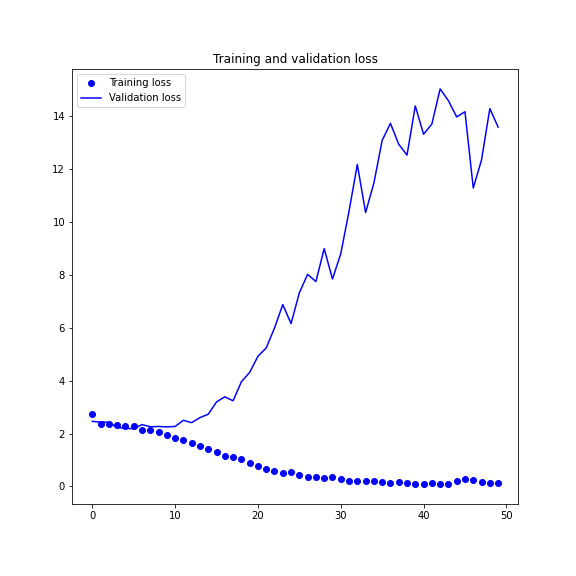
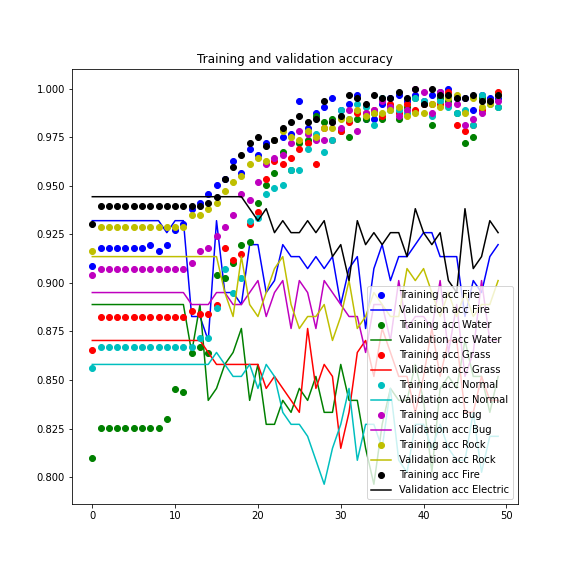

The trainig accuracies were overall a lot higher than the validation accuracies of each of the tasks, while the validation lost was a lot higher than the loss. The model was overfitted, even with fewer epochs the model would have stayed at a high loss, since loss and validation loss start to diverge at a value of around 2. The model is doing very poorly as well. 

We can also see that the individual losses of each task are all lower than 0. The accuracy of this model, however, did better than the previous models. The general model had accuracy of 25 (validation) and 30% (training), and the first multi-task model of 15% (primary task) to 50% (secondary task). This model, on the other hand, reached accuracy of over 80% in all the tasks. 

We see some examples of prediction for this model:

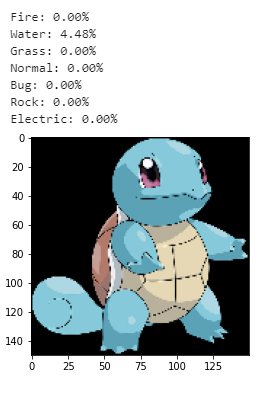
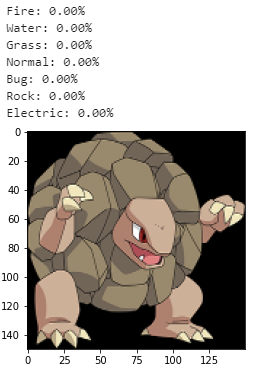
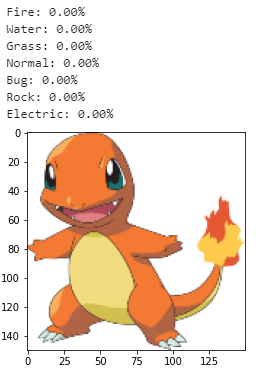
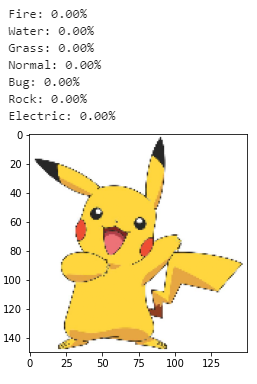

As with previous examples, we have:

- Squirtle is a primary water type and has no secondary type. 
- Golem is a primary rock type and secondary ground type. 
- Charmander is a fire primary type and has no secondary type. 
- Pikachu is a electric primary type with no secondary type.  

The model could not predict any of the types from the pokemon. This was expected because the model was not very good. An effort was made to predict Squirtle with a water type 4.48%, this is, however, very low. 

The models are clearly very bad, the fine-task model of 7 branches seeming to be the worst with very high loss. This seems to indicate that considering only the accuracy as a measure of how good the model is, is also not a good choice. In this case, each task only needs to focus on determining if the pokemon belongs to a single class or not, which makes the training data very unbalanced. There are 18 branches, so from the 809 images only very few will actually correspond to the classification of each branch. More images will be labeled as not being part of said classification or type. In the end the model is very bad, but has a higher percentage than the rest because it had such unbalanced data to train. 

## VGG inclusion

Finally, there will be an attempt to make the models better. Since the dataset is small, we will try to combine transfer learning using a trained VGG to extract features and make use of them before training any layers. With the features extracted as a common branch, tasks may sub-branch to make the different tasks.

In [2]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import matplotlib.pyplot as plt
from ipynb.fs.full.utilities import *

In [30]:
class PokemonNet:
    
    @staticmethod
    def build_type1_branch(inputs, numType1, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(numType1)(x)
        x = Activation(finalAct, name="type1_classification")(x)
        
        return x
        
    @staticmethod
    def build_type2_branch(inputs, numType2, finalAct="sigmoid"):
        
        x = Flatten()(inputs)
        # add two fully connected layers and some dropout
        x = Dense(256)(x)
        x = Activation('relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(numType2)(x)
        x = Activation(finalAct, name="type2_classification")(x)
        
        return x
    
    @staticmethod
    def build_model(input_shape, numType1, numType2, finalAct="sigmoid"):
        
        inputs = Input(shape=input_shape)

        """
        # CONV => RELU => POOL
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        
        # (CONV => RELU) * 2 => POOL
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # (CONV => RELU) * 2 => POOL
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        """
        
        # Constructing type 1 and type 2 heads.
        type1_branch = PokemonNet.build_type1_branch(inputs, numType1, finalAct)
        type2_branch = PokemonNet.build_type2_branch(inputs, numType2, finalAct)
        
        # Building the model
        print("Building model...")
        model = Model(
            inputs=inputs,
            outputs=[type1_branch, type2_branch],
            name="pokemonnet"
                     )
        
        return model    
    
    @staticmethod
    def net_generator(generator, data, label1, label2, batch_s):
        gen1 = generator.flow(data, label1, batch_size=batch_s)
        gen2 = generator.flow(data, label2, batch_size=batch_s)
        while True:
            X1 = gen1.next()
            X2 = gen2.next()
            yield X1[0], [X1[1], X2[1]] 
    
        
        
        

In [46]:
EPOCHS = 50
BATCH_SIZE = 28
INIT_LR = 1e-3
IMG_DIMS = [150, 150]
ACTIVATION = 'sigmoid'


# Extracting images
data = load_images('images\images', IMG_DIMS)

# Values between [0, 1]
data = np.array(data, dtype='float')/255.0
#plt.imshow(data[0,:,:,:])

data_layer3 = np.load('features/train.npy')


# Binarize sets of labels
type1LB = LabelBinarizer()
type2LB = LabelBinarizer()
type1Labels = type1LB.fit_transform(getTypeLabels('pokemon_2.csv', 'Type1'))
type2Labels = type2LB.fit_transform(getTypeLabels('pokemon_2.csv', 'Type2'))

#ptypeLabels = label_dataset('Bug', 'pokemon_2.csv')
#print(ptypeLabels)

# Split data into training and validation
split = train_test_split(data_layer3, type1Labels, type2Labels, test_size=0.2)
(trainX, testX, trainType1Y, testType1Y, trainType2Y, testType2Y) = split

"""
# build the VGG16 network, leaving off the top classifier layer
# so we just get the features as output
print('Building VGG16...')
inputs = Input(shape=(IMG_DIMS[0], IMG_DIMS[1], 3))
base_model = VGG16(weights='imagenet', include_top=False,
        input_tensor=inputs)

# Save training features
datagen = ImageDataGenerator()
generator = datagen.flow(
    trainX,
    batch_size=BATCH_SIZE,
    shuffle=False)

print('Saving bottleneck features (train)...')
bottleneck_features_train = base_model.predict(
    generator, trainX.shape[0] // BATCH_SIZE)
np.save('features/train.npy', bottleneck_features_train)

# Save validation features
generator = datagen.flow(
    testX,
    batch_size=BATCH_SIZE,
    shuffle=False)

print('Saving bottleneck features (validation)...')
bottleneck_features_validation = base_model.predict(
    generator, testX.shape[0] // BATCH_SIZE)
np.save('features/validation.npy',
        bottleneck_features_validation)
"""

# defining dictionary with respective losses.
losses = {
    "type1_classification": "categorical_crossentropy",
    "type2_classification": "categorical_crossentropy",
}

# Creating model
model = PokemonNet.build_model(data_layer3.shape[1:], 
                               numType1=len(type1LB.classes_),
                               numType2=len(type2LB.classes_),
                               finalAct= ACTIVATION)

model.compile(optimizer='adam', loss=losses, metrics=["accuracy"])

# Displaying model summary
model.summary()

# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

"""
# train the network to perform multi-output classification
H = model.fit(x=trainX, 
        y={"type1_classification": trainType1Y, "type2_classification": trainType2Y},
        validation_data=(testX, 
            {"type1_classification": testType1Y, "type2_classification": testType2Y}),
        steps_per_epoch=len(trainX)/BATCH_SIZE,
        validation_steps=len(testX)/BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1)
"""

# train the network to perform multi-output classification
H = model.fit(trainX, y={ "type1_classification": trainType1Y, "type2_classification": trainType2Y},
        validation_data= (testX, {"type1_classification": testType1Y, "type2_classification": testType2Y}),
        steps_per_epoch=len(trainX)/BATCH_SIZE,
        validation_steps=len(testX)/BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1)

Building model...
Model: "pokemonnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 37, 37, 256) 0                                            
__________________________________________________________________________________________________
flatten_24 (Flatten)            (None, 350464)       0           input_33[0][0]                   
__________________________________________________________________________________________________
flatten_25 (Flatten)            (None, 350464)       0           input_33[0][0]                   
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 256)          89719040    flatten_24[0][0]                 
_______________________________________________________________________

In [49]:
# Save model
model.save('pokemon_model_14.h5', save_format='h5' )

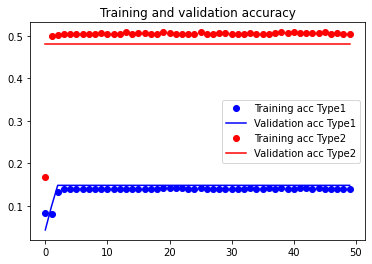

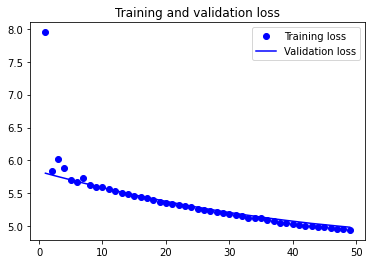

In [48]:
# Plot results

acc1 = H.history['type1_classification_accuracy']
acc2 = H.history['type2_classification_accuracy']
val_acc1 = H.history['val_type1_classification_accuracy']
val_acc2 = H.history['val_type2_classification_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(len(acc1))

plt.plot(epochs, acc1, 'bo', label='Training acc Type1')
plt.plot(epochs, val_acc1, 'b', label='Validation acc Type1')
plt.plot(epochs, acc2, 'ro', label='Training acc Type2')
plt.plot(epochs, val_acc2, 'r', label='Validation acc Type2')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("model14_1.png")
plt.figure()

plt.plot(epochs[1:], loss[1:], 'bo', label='Training loss')
plt.plot(epochs[1:], val_loss[1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("model14_2.png")
plt.show()


In [64]:
# Test model
MODEL_PATH='pokemon_model_14.h5'
TEST_IMAGE='images/images/squirtle.png'
FEATURES = np.load('features/pikachu.npy')

# load the image
image = cv2.imread(TEST_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# pre-process the image for classification
image = cv2.resize(image, (150, 150))
image = image.astype("float") / 255.0
image = img_to_array(image)
#plt.imshow(image)
image = np.expand_dims(image, axis=0)

# loading model
print("[INFO] loading network...")
model = load_model(MODEL_PATH)

# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
type1Proba, type2Proba = model.predict(FEATURES)
type1Idx = type1Proba[0].argmax()
type2Idx = type2Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]
type2LabelRes = type2LB.classes_[type2Idx]

print("\n Pikachu")
print(f'\n Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n Type2: {type2LabelRes} Probability: {type2Proba[0][type2Idx] * 100:.2f}%')



[INFO] loading network...
[INFO] classifying image...

 Pikachu

 Type1: Water Probability: 64.50% 
 Type2: None Probability: 74.25%


In [64]:
# Test model
MODEL_PATH='pokemon_model_14.h5'
TEST_IMAGE='images/images/squirtle.png'
FEATURES = np.load('features/pikachu.npy')

# load the image
image = cv2.imread(TEST_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# pre-process the image for classification
image = cv2.resize(image, (150, 150))
image = image.astype("float") / 255.0
image = img_to_array(image)
#plt.imshow(image)
image = np.expand_dims(image, axis=0)

# loading model
print("[INFO] loading network...")
model = load_model(MODEL_PATH)

# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
type1Proba, type2Proba = model.predict(FEATURES)
type1Idx = type1Proba[0].argmax()
type2Idx = type2Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]
type2LabelRes = type2LB.classes_[type2Idx]

print("\n Pikachu")
print(f'\n Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n Type2: {type2LabelRes} Probability: {type2Proba[0][type2Idx] * 100:.2f}%')



[INFO] loading network...
[INFO] classifying image...

 Pikachu

 Type1: Water Probability: 64.50% 
 Type2: None Probability: 74.25%


In [66]:
# Test model
MODEL_PATH='pokemon_model_14.h5'
FEATURES = np.load('features/pikachu.npy')
FEATURES1 = np.load('features/water.npy')
FEATURES2 = np.load('features/fire.npy')
FEATURES3 = np.load('features/test1.npy')

# classify the input image using Keras' multi-output functionality
print("[INFO] classifying image...")
type1Proba, type2Proba = model.predict(FEATURES)
type1Idx = type1Proba[0].argmax()
type2Idx = type2Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]
type2LabelRes = type2LB.classes_[type2Idx]

print("\n Pikachu")
print(f'\n Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n Type2: {type2LabelRes} Probability: {type2Proba[0][type2Idx] * 100:.2f}%')

print("[INFO] classifying image...")
type1Proba, type2Proba = model.predict(FEATURES1)
type1Idx = type1Proba[0].argmax()
type2Idx = type2Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]
type2LabelRes = type2LB.classes_[type2Idx]

print("\n Squirtle")
print(f'\n Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n Type2: {type2LabelRes} Probability: {type2Proba[0][type2Idx] * 100:.2f}%')


print("[INFO] classifying image...")
type1Proba, type2Proba = model.predict(FEATURES2)
type1Idx = type1Proba[0].argmax()
type2Idx = type2Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]
type2LabelRes = type2LB.classes_[type2Idx]

print("\n Charmander")
print(f'\n Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n Type2: {type2LabelRes} Probability: {type2Proba[0][type2Idx] * 100:.2f}%')

print("[INFO] classifying image...")
type1Proba, type2Proba = model.predict(FEATURES3)
type1Idx = type1Proba[0].argmax()
type2Idx = type2Proba[0].argmax()
type1LabelRes = type1LB.classes_[type1Idx]
type2LabelRes = type2LB.classes_[type2Idx]

print("\n Golem")
print(f'\n Type1: {type1LabelRes} Probability: {type1Proba[0][type1Idx] * 100:.2f}% \n Type2: {type2LabelRes} Probability: {type2Proba[0][type2Idx] * 100:.2f}%')




[INFO] classifying image...

 Pikachu

 Type1: Water Probability: 64.50% 
 Type2: None Probability: 74.25%
[INFO] classifying image...

 Squirtle

 Type1: Water Probability: 64.50% 
 Type2: None Probability: 74.25%
[INFO] classifying image...

 Charmander

 Type1: Water Probability: 64.50% 
 Type2: None Probability: 74.25%
[INFO] classifying image...

 Golem

 Type1: Water Probability: 64.50% 
 Type2: None Probability: 74.25%
